In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Importar librerías necesarias RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Importar librerías necesarias ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_historic_order_demand.xlsx"
df_historic_order_demand = pd.read_excel(path_df_location)

df_historic_order_demand


cliente mes_anio  order_demand
0     Cliente_1  12-2020         857.0
1     Cliente_2  12-2020         941.0
2     Cliente_3  12-2020         878.0
3     Cliente_4  12-2020         949.0
4     Cliente_5  12-2020         932.0
..          ...      ...           ...
975  Cliente_16  12-2024         891.0
976  Cliente_17  12-2024         968.0
977  Cliente_18  12-2024         972.0
978  Cliente_19  12-2024         901.0
979  Cliente_20  12-2024         881.0

[980 rows x 3 columns]

In [3]:
# Explorar la estructura del DataFrame
print("Primeras filas del DataFrame:")
print(df_historic_order_demand.head())

print("\nInformación del DataFrame:")
print(df_historic_order_demand.info())

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(df_historic_order_demand.isnull().sum())


Primeras filas del DataFrame:
     cliente mes_anio  order_demand
0  Cliente_1  12-2020         857.0
1  Cliente_2  12-2020         941.0
2  Cliente_3  12-2020         878.0
3  Cliente_4  12-2020         949.0
4  Cliente_5  12-2020         932.0

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cliente       980 non-null    object 
 1   mes_anio      980 non-null    object 
 2   order_demand  932 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.1+ KB
None

Valores nulos por columna:
cliente          0
mes_anio         0
order_demand    48
dtype: int64


In [36]:
# Crear un nuevo DataFrame a partir del original
df_historicod_time = df_historic_order_demand.copy()

# Añadir la nueva columna 'mes_anio_dia' asumiendo el primer día del mes para todas las entradas
df_historicod_time['mes_anio_dia'] = pd.to_datetime(df_historicod_time['mes_anio'].apply(lambda x: f"01-{x}"), format='%d-%m-%Y', errors='coerce')

# Verificar si hay valores nulos en la nueva columna en el nuevo DataFrame
print("\nValores nulos en 'mes_anio_dia' del nuevo DataFrame:")
print(df_historicod_time['mes_anio_dia'].isnull().sum())



Valores nulos en 'mes_anio_dia' del nuevo DataFrame:
0


In [37]:
# Verificar si hay duplicados basados en 'cliente' y 'mes_anio_dia' en el nuevo DataFrame
print("Registros duplicados en df_historicod_time:")
print(df_historicod_time.duplicated(subset=['cliente', 'mes_anio_dia']).sum())

df_historicod_time

Registros duplicados en df_historicod_time:
0


cliente mes_anio  order_demand mes_anio_dia
0     Cliente_1  12-2020         857.0   2020-12-01
1     Cliente_2  12-2020         941.0   2020-12-01
2     Cliente_3  12-2020         878.0   2020-12-01
3     Cliente_4  12-2020         949.0   2020-12-01
4     Cliente_5  12-2020         932.0   2020-12-01
..          ...      ...           ...          ...
975  Cliente_16  12-2024         891.0   2024-12-01
976  Cliente_17  12-2024         968.0   2024-12-01
977  Cliente_18  12-2024         972.0   2024-12-01
978  Cliente_19  12-2024         901.0   2024-12-01
979  Cliente_20  12-2024         881.0   2024-12-01

[980 rows x 4 columns]

In [38]:
# Ordenar primero por cliente y luego por mes_anio_dia en df_historicod_time
df_historicod_time = df_historicod_time.sort_values(by=['cliente', 'mes_anio_dia']).reset_index(drop=True)

# Verificar la estructura después de ordenar
print("Estructura de df_historicod_time después de ordenar:")
print(df_historicod_time.head())


Estructura de df_historicod_time después de ordenar:
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


In [39]:
# Mostrar número de valores nulos en la columna 'order_demand' de df_historicod_time
print("\nValores nulos en 'order_demand' de df_historicod_time:")
print(df_historicod_time['order_demand'].isnull().sum())

# Mostrar las filas que contienen valores nulos en 'order_demand' en df_historicod_time
print("\nFilas con valores nulos en 'order_demand' de df_historicod_time:")
print(df_historicod_time[df_historicod_time['order_demand'].isnull()])



Valores nulos en 'order_demand' de df_historicod_time:
48

Filas con valores nulos en 'order_demand' de df_historicod_time:
        cliente mes_anio  order_demand mes_anio_dia
55   Cliente_10  06-2021           NaN   2021-06-01
65   Cliente_10  04-2022           NaN   2022-04-01
89   Cliente_10  04-2024           NaN   2024-04-01
92   Cliente_10  07-2024           NaN   2024-07-01
109  Cliente_11  11-2021           NaN   2021-11-01
124  Cliente_11  02-2023           NaN   2023-02-01
128  Cliente_11  06-2023           NaN   2023-06-01
140  Cliente_11  06-2024           NaN   2024-06-01
169  Cliente_12  10-2022           NaN   2022-10-01
173  Cliente_12  02-2023           NaN   2023-02-01
205  Cliente_13  09-2021           NaN   2021-09-01
211  Cliente_13  03-2022           NaN   2022-03-01
229  Cliente_13  09-2023           NaN   2023-09-01
234  Cliente_13  02-2024           NaN   2024-02-01
253  Cliente_14  08-2021           NaN   2021-08-01
254  Cliente_14  09-2021           NaN   20

In [40]:
# Sustituir valores nulos en 'order_demand' por la media del cliente en df_historicod_time
df_historicod_time['order_demand'] = df_historicod_time.groupby('cliente')['order_demand'].transform(lambda x: x.fillna(x.mean()))

# Verificar si quedan valores nulos
print("\nVerificación de valores nulos después de la sustitución en 'order_demand':")
print(df_historicod_time['order_demand'].isnull().sum())

# Mostrar algunas filas para verificar cambios
print(df_historicod_time.head())



Verificación de valores nulos después de la sustitución en 'order_demand':
0
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


Dividir los Datos por Cliente


In [41]:
# Crear un diccionario para almacenar los datos por cliente
clientes_data = {}

# Iterar por cada cliente único y guardar sus datos en un DataFrame
for cliente in df_historicod_time['cliente'].unique():
    datos_cliente = df_historicod_time[df_historicod_time['cliente'] == cliente]
    
    # Solo incluir si hay datos válidos para análisis temporal
    if datos_cliente['order_demand'].notnull().sum() > 12:  # Al menos 12 puntos de datos
        clientes_data[cliente] = datos_cliente

# Confirmar cuántos clientes tienen datos suficientes para análisis
print(f"{len(clientes_data)} clientes tienen datos suficientes para análisis temporal.")

clientes_data

20 clientes tienen datos suficientes para análisis temporal.


{'Cliente_1':       cliente mes_anio  order_demand mes_anio_dia
 0   Cliente_1  12-2020         857.0   2020-12-01
 1   Cliente_1  01-2021         768.0   2021-01-01
 2   Cliente_1  02-2021         635.0   2021-02-01
 3   Cliente_1  03-2021         631.0   2021-03-01
 4   Cliente_1  04-2021         589.0   2021-04-01
 5   Cliente_1  05-2021         785.0   2021-05-01
 6   Cliente_1  06-2021         798.0   2021-06-01
 7   Cliente_1  07-2021         599.0   2021-07-01
 8   Cliente_1  08-2021         570.0   2021-08-01
 9   Cliente_1  09-2021         589.0   2021-09-01
 10  Cliente_1  10-2021        1848.0   2021-10-01
 11  Cliente_1  11-2021         597.0   2021-11-01
 12  Cliente_1  12-2021         886.0   2021-12-01
 13  Cliente_1  01-2022         699.0   2022-01-01
 14  Cliente_1  02-2022         609.0   2022-02-01
 15  Cliente_1  03-2022         633.0   2022-03-01
 16  Cliente_1  04-2022         563.0   2022-04-01
 17  Cliente_1  05-2022         816.0   2022-05-01
 18  Cliente_1  06

EDA clientes_data

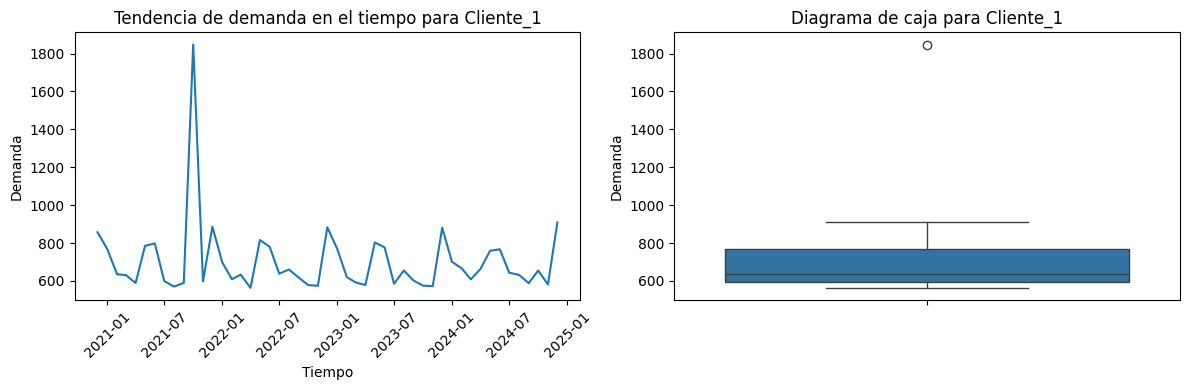

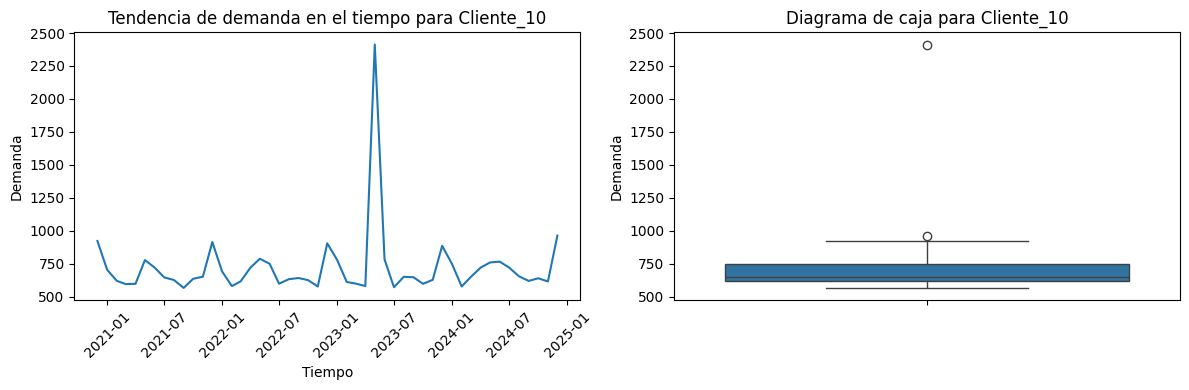

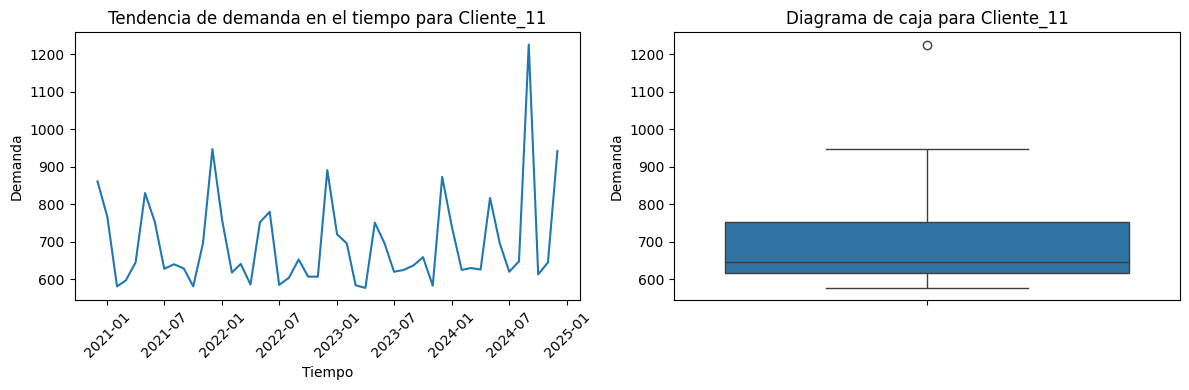

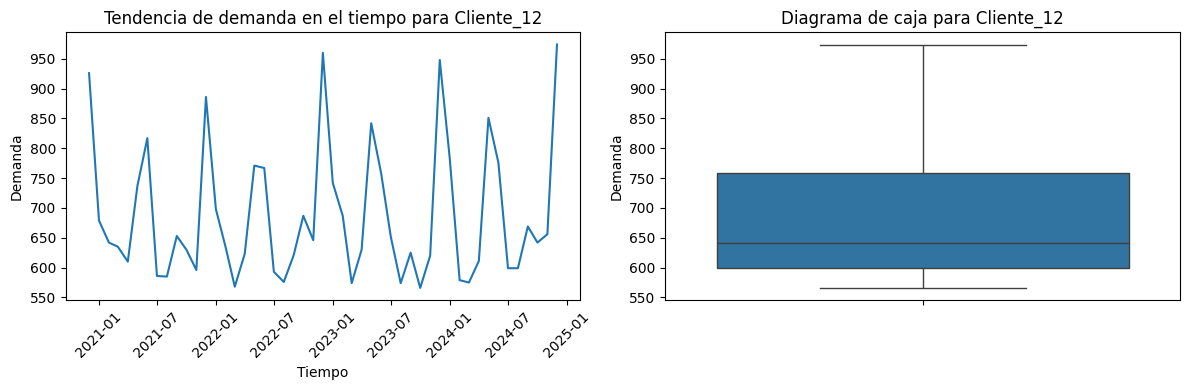

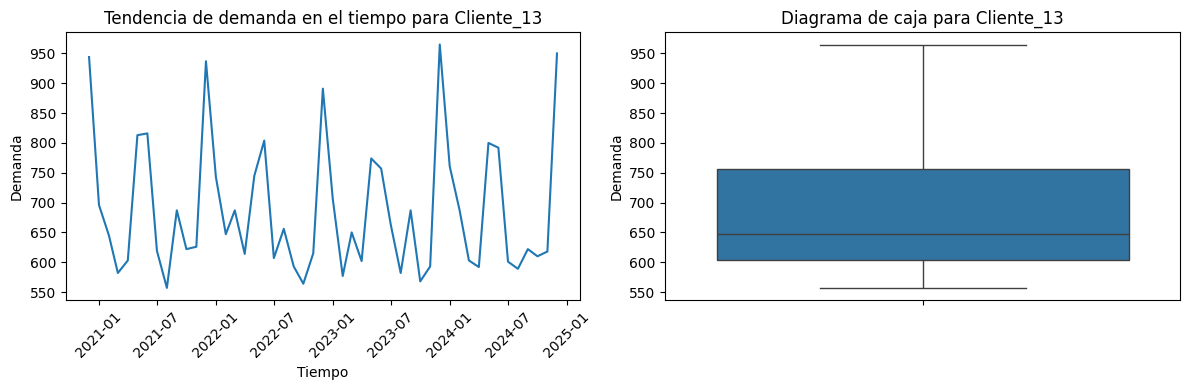

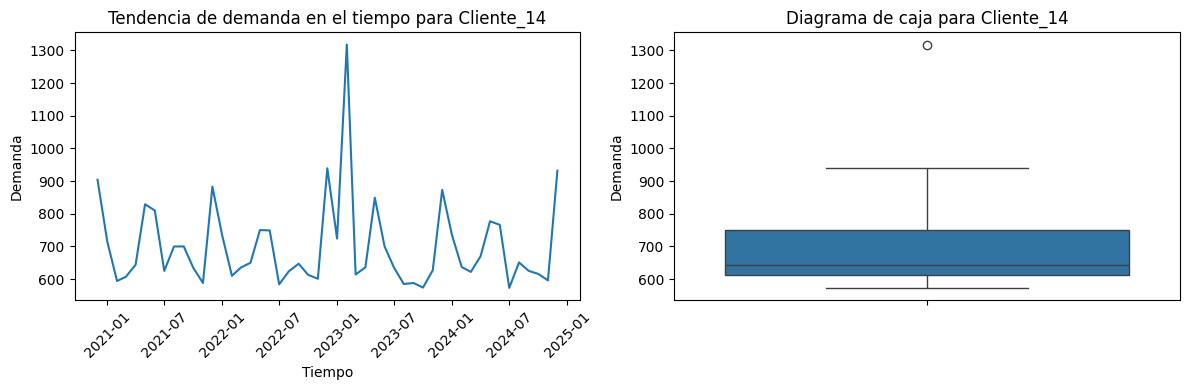

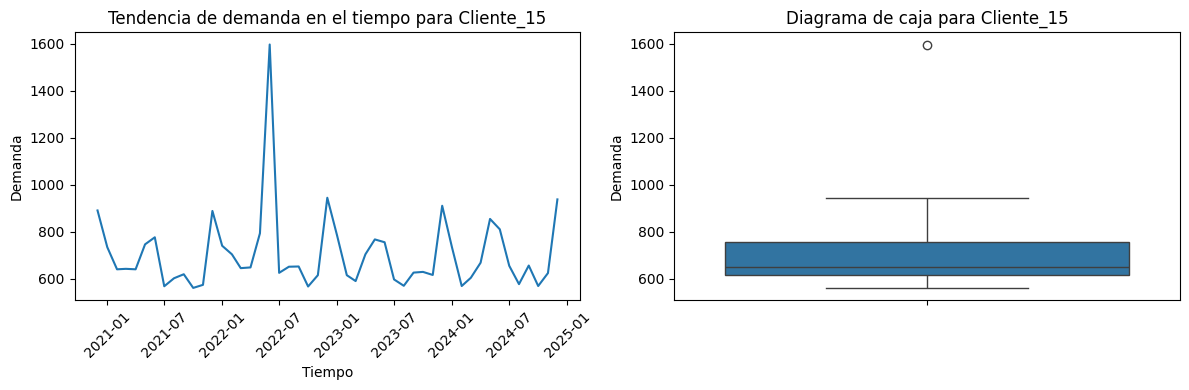

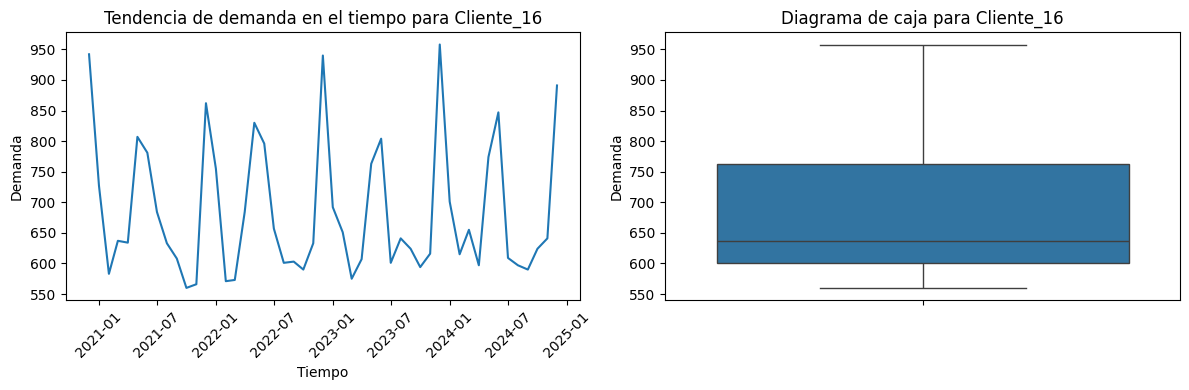

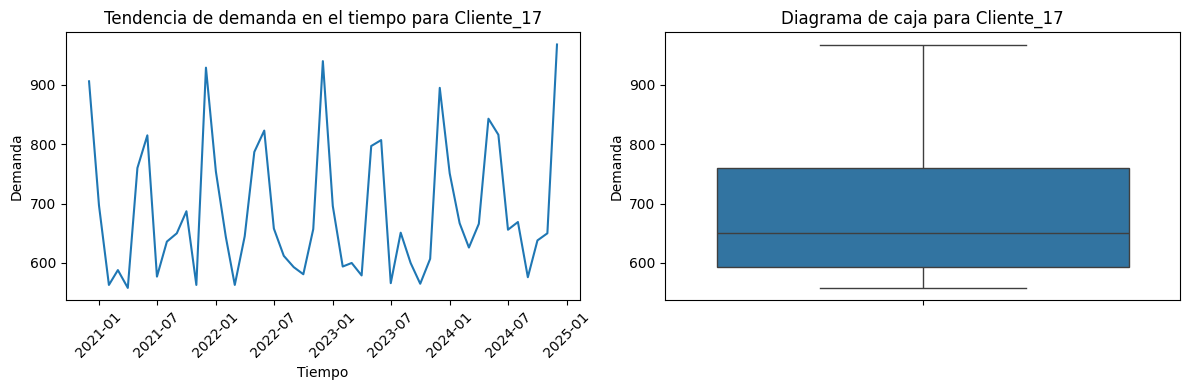

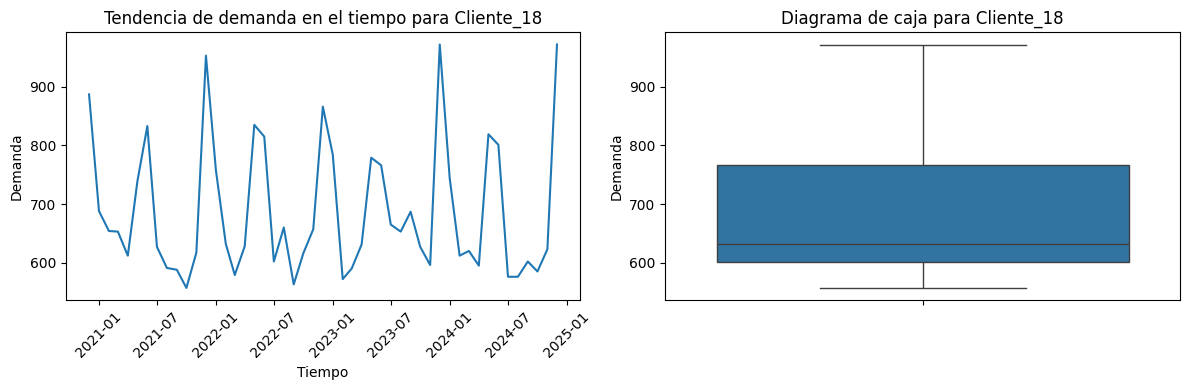

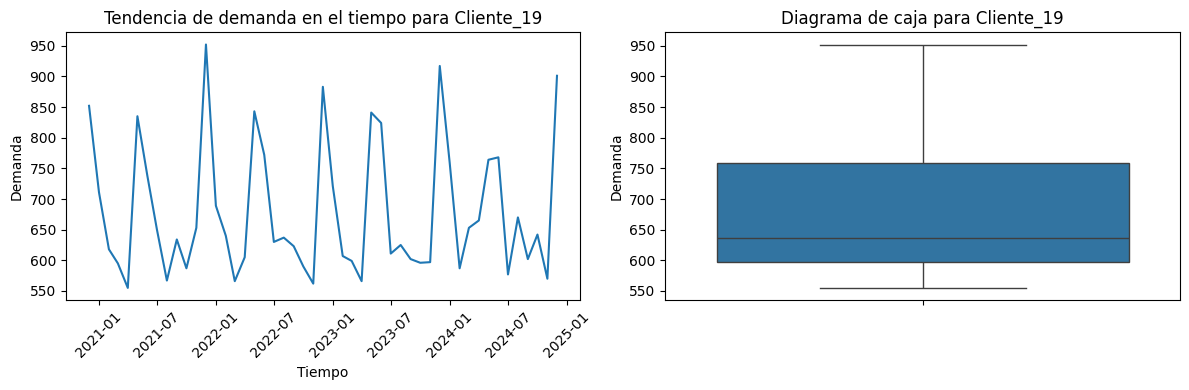

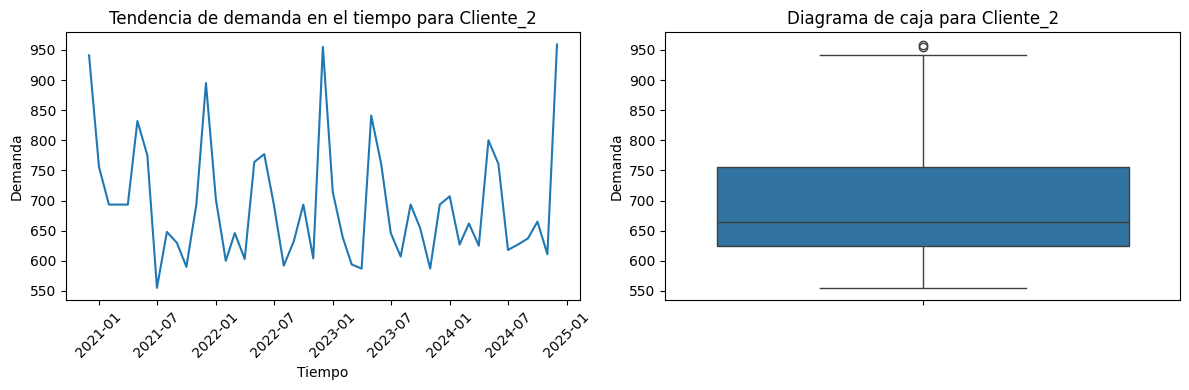

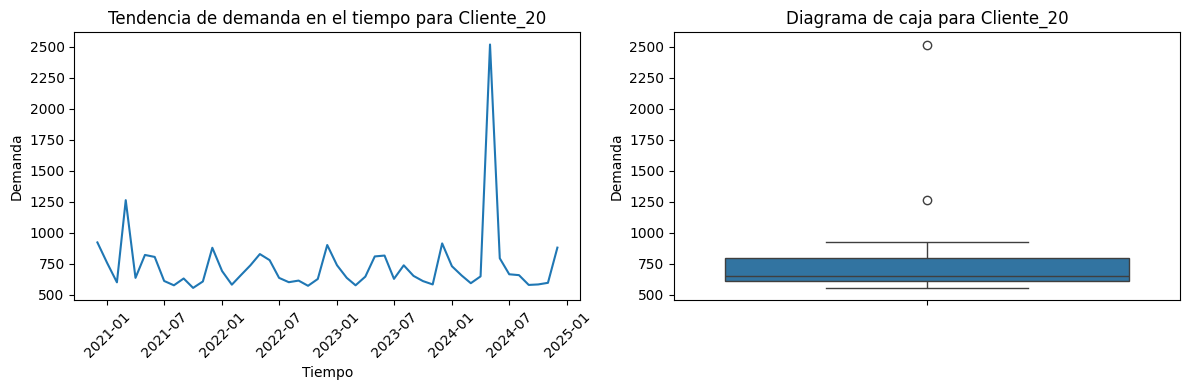

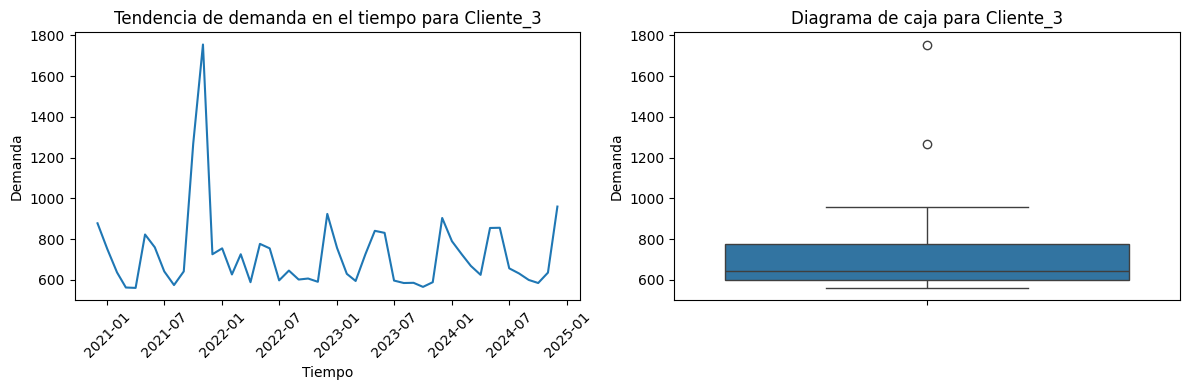

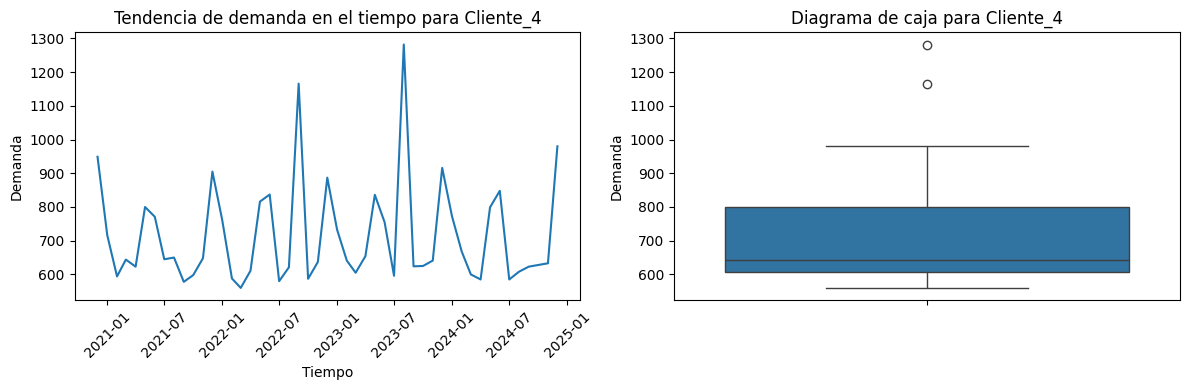

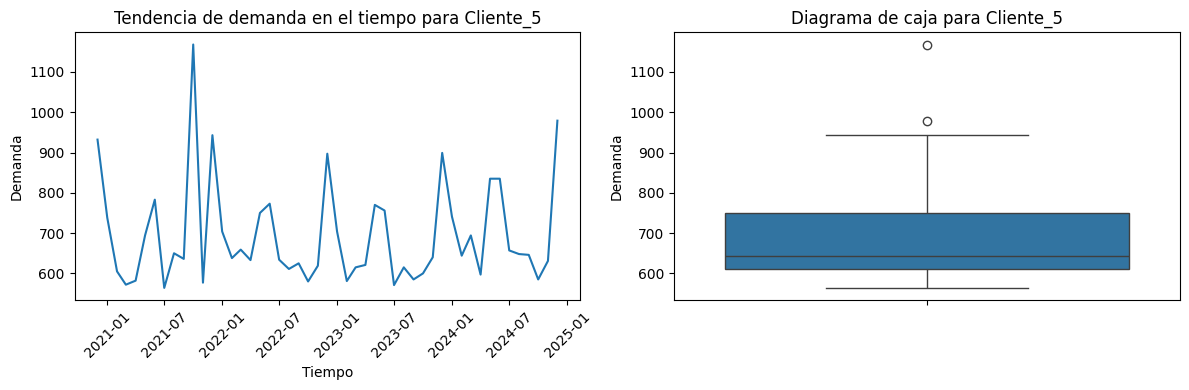

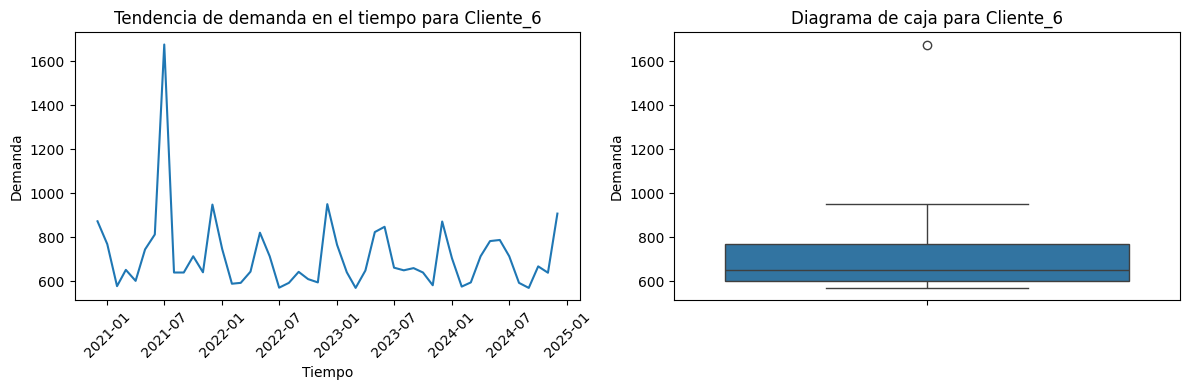

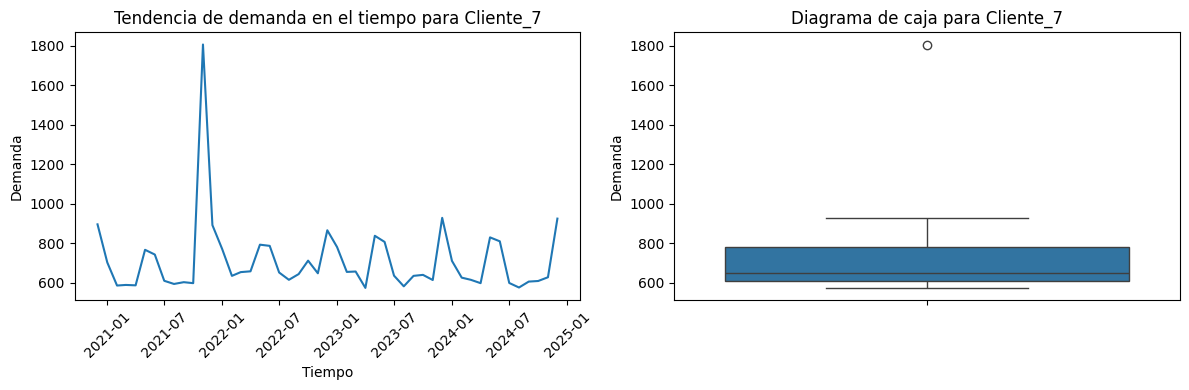

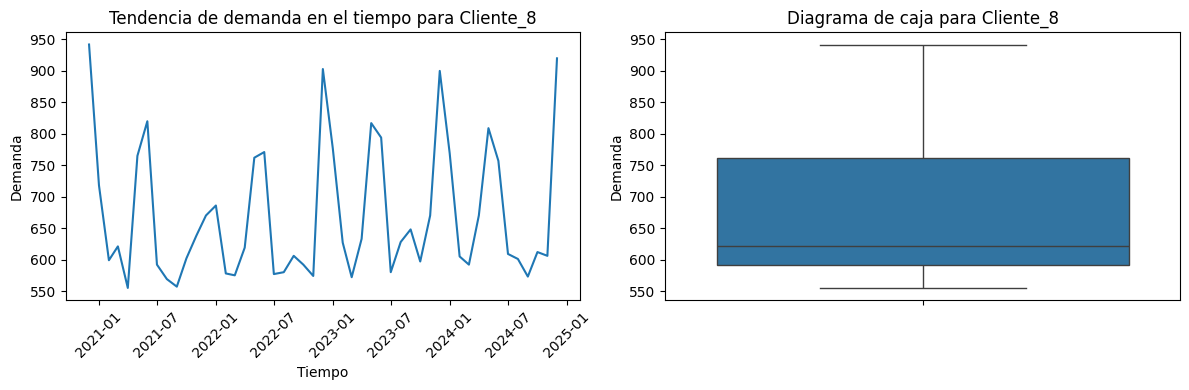

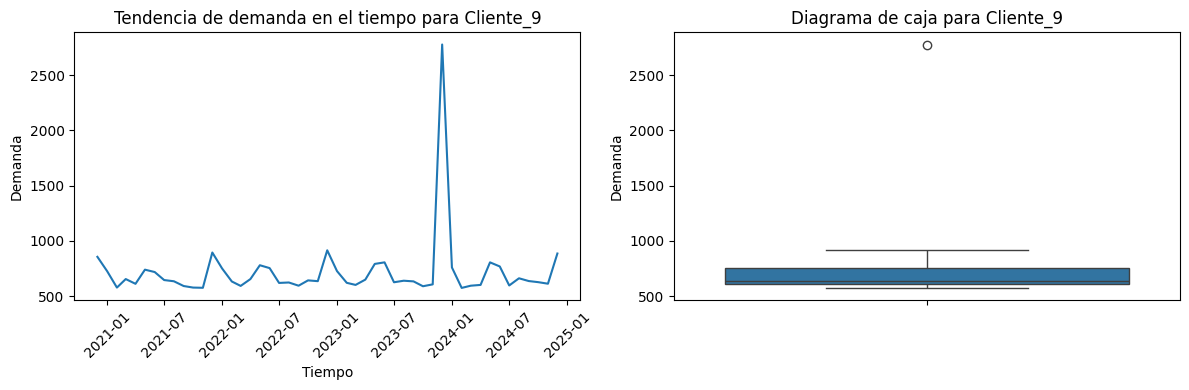

In [10]:
# Visualización de Tendencias y Patrones:

for cliente, df in clientes_data.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas
    
    # Histograma de la demanda a lo largo del tiempo
    sns.lineplot(data=df, x='mes_anio_dia', y='order_demand', ax=axes[0])
    axes[0].set_title(f"Tendencia de demanda en el tiempo para {cliente}")
    axes[0].set_xlabel("Tiempo")
    axes[0].set_ylabel("Demanda")
    axes[0].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X si es necesario

    # Diagrama de caja con 'order_demand' en el eje Y
    sns.boxplot(y=df['order_demand'], ax=axes[1])
    axes[1].set_title(f"Diagrama de caja para {cliente}")
    axes[1].set_ylabel("Demanda")
    
    plt.tight_layout()  # Ajusta el espaciado entre gráficos
    plt.show()


1. Descomposición de Series Temporales

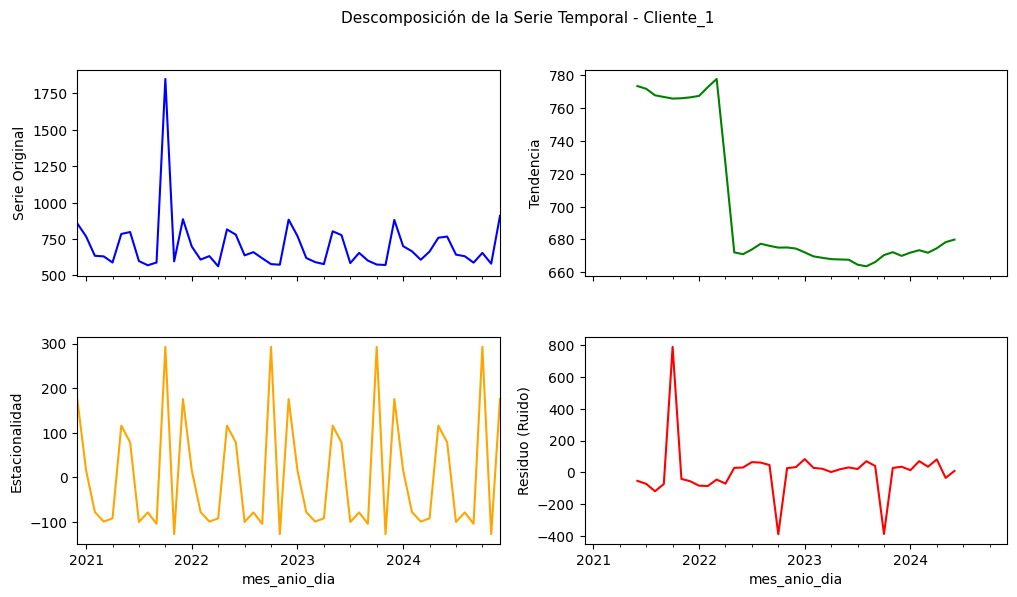

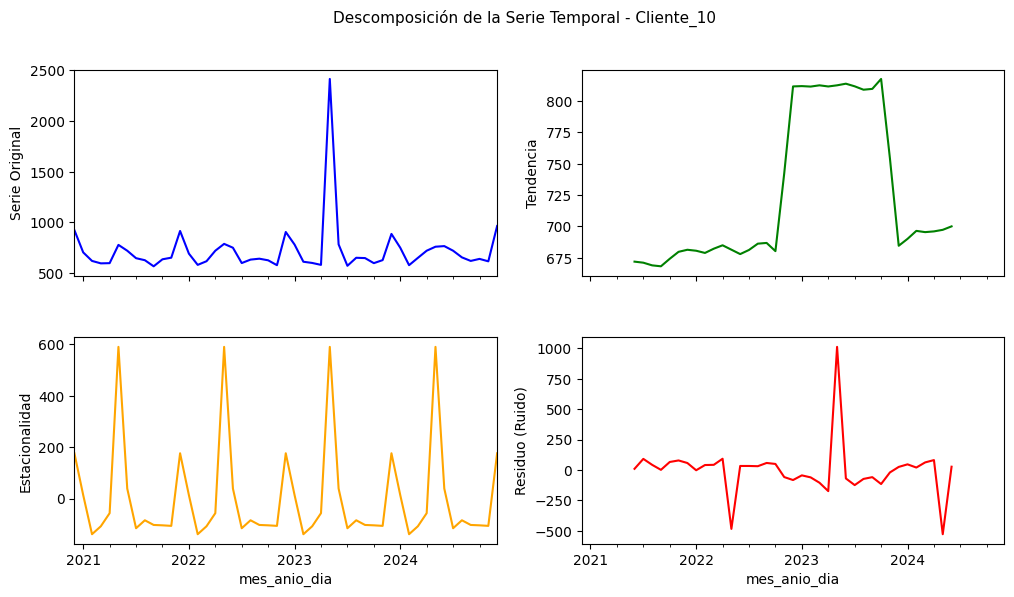

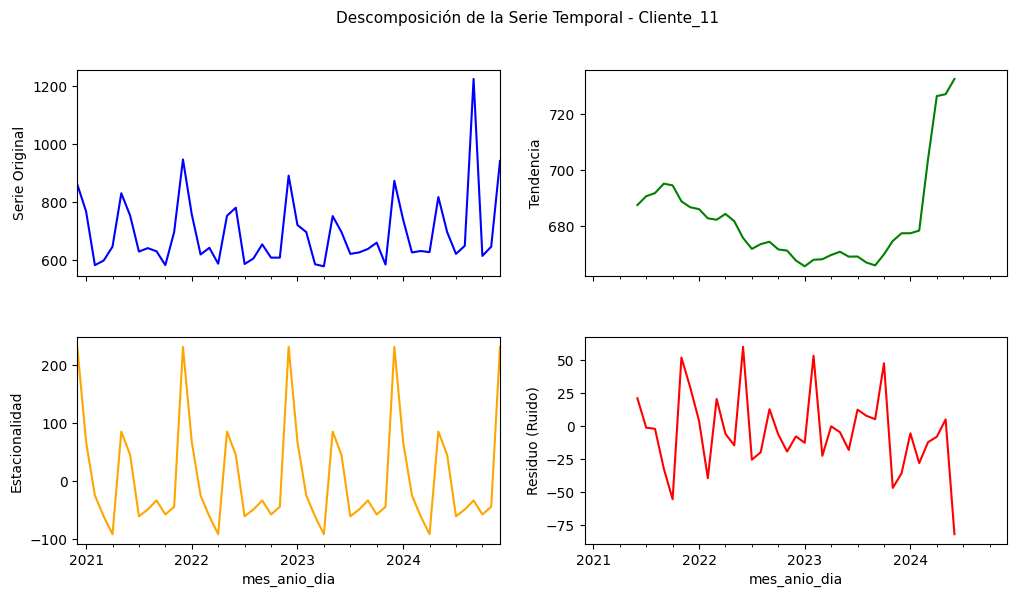

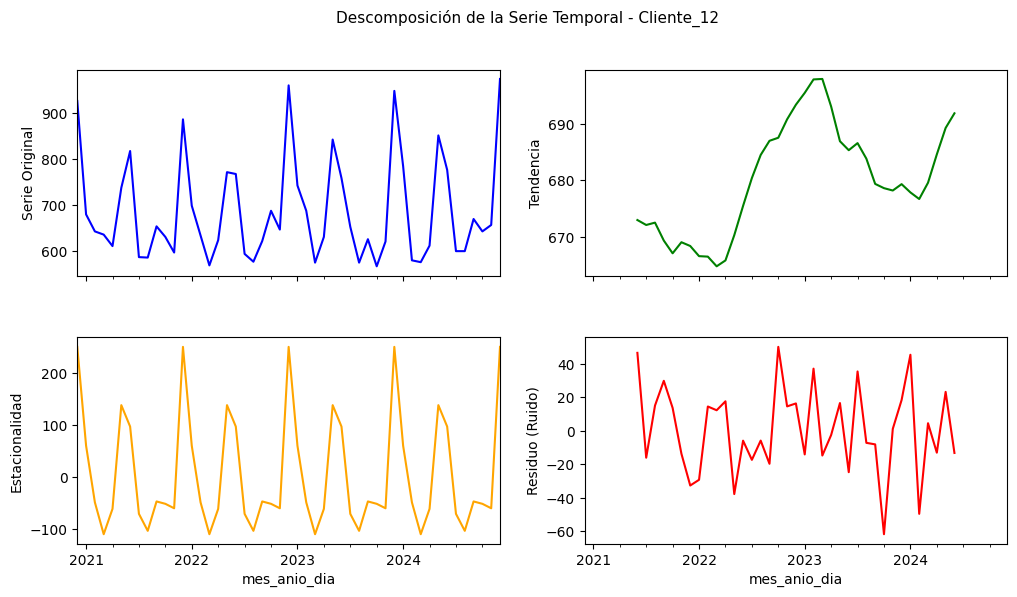

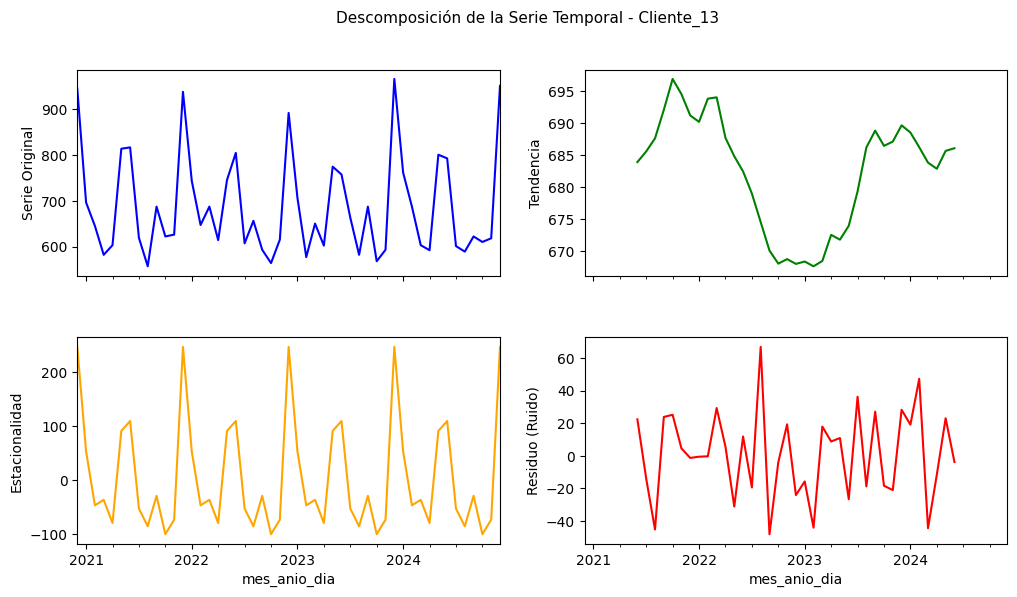

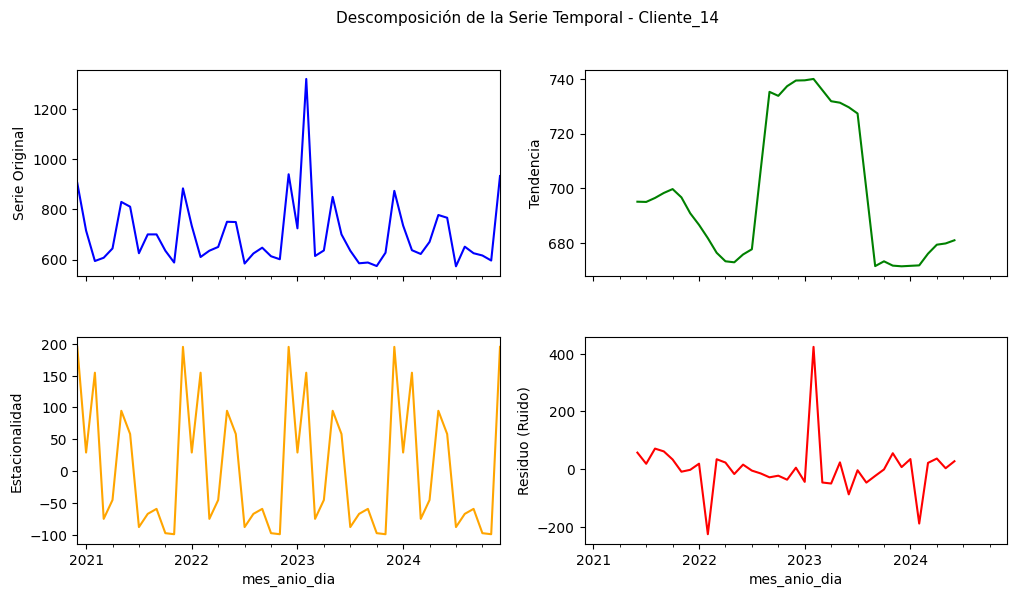

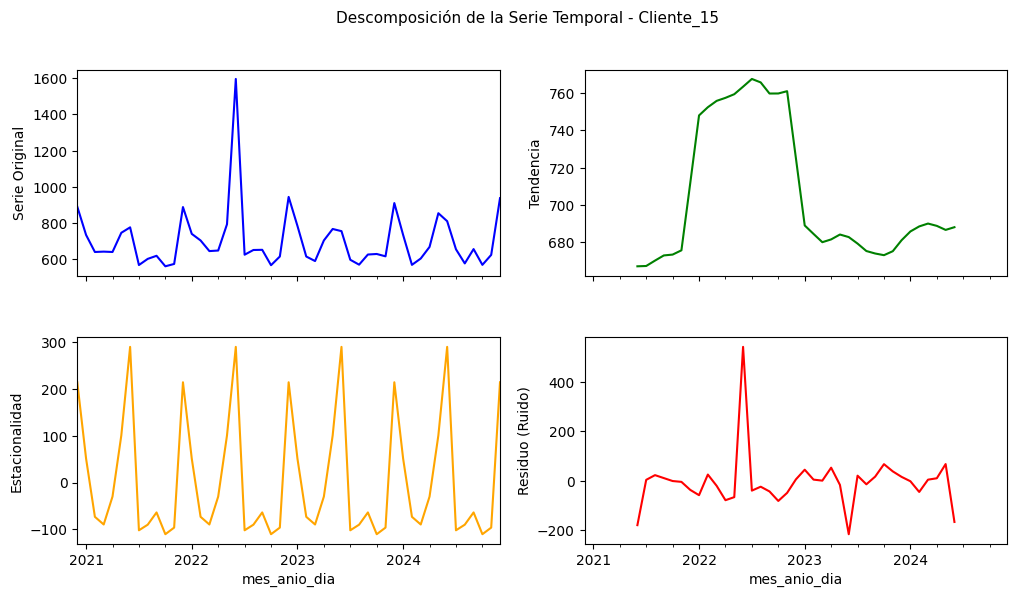

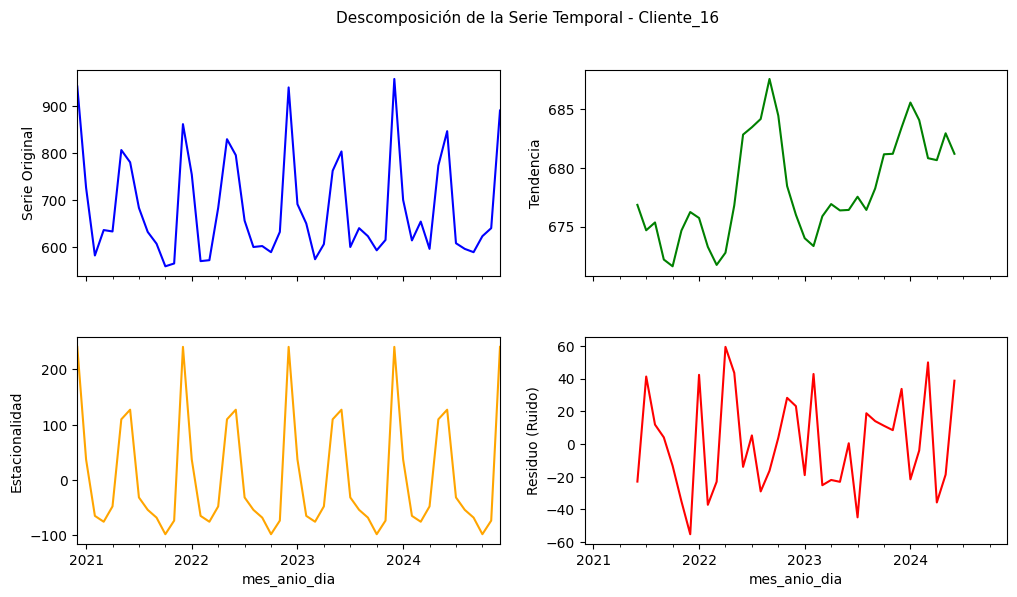

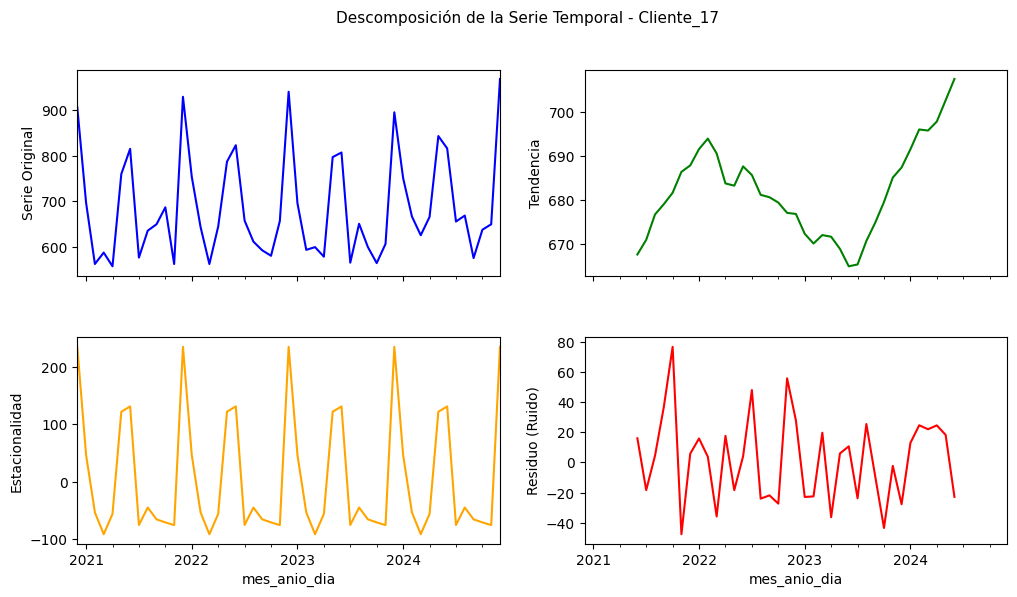

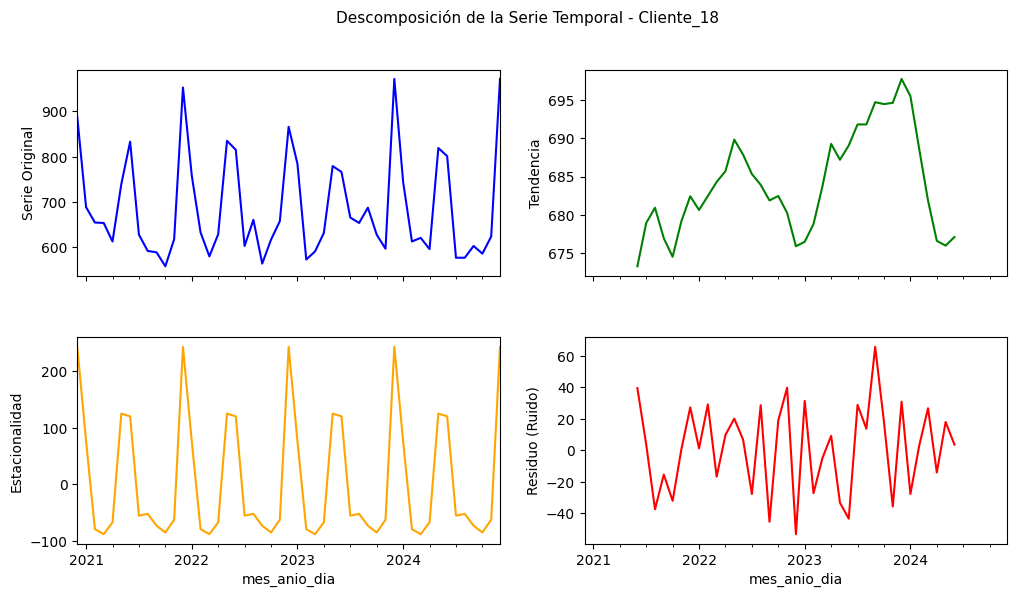

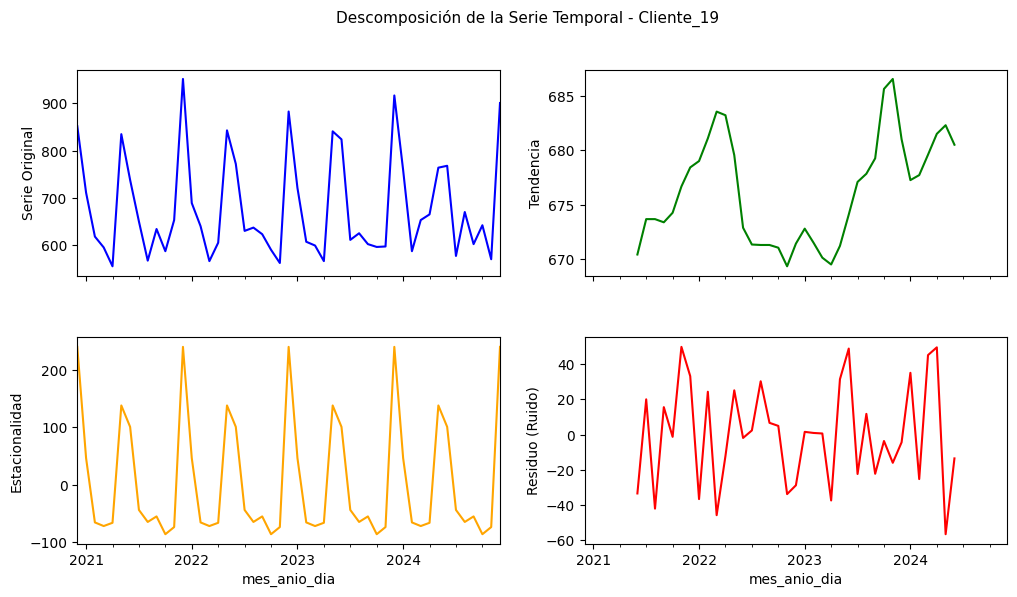

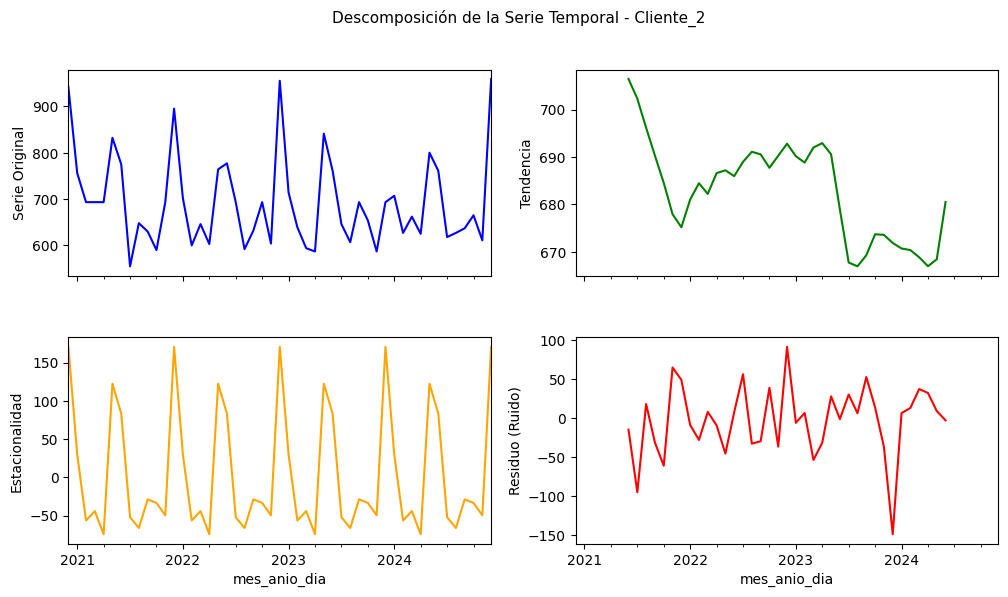

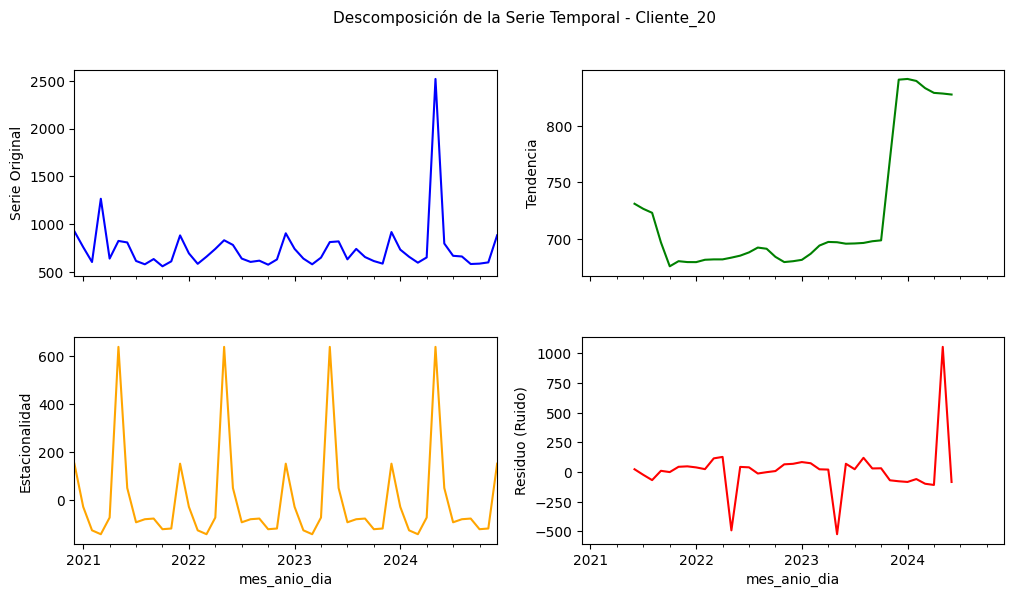

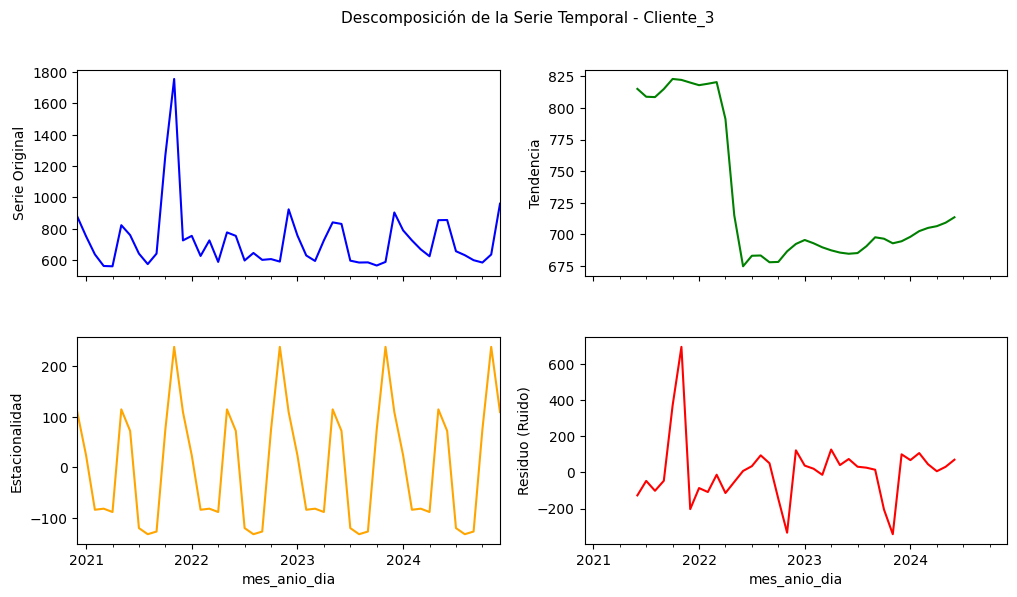

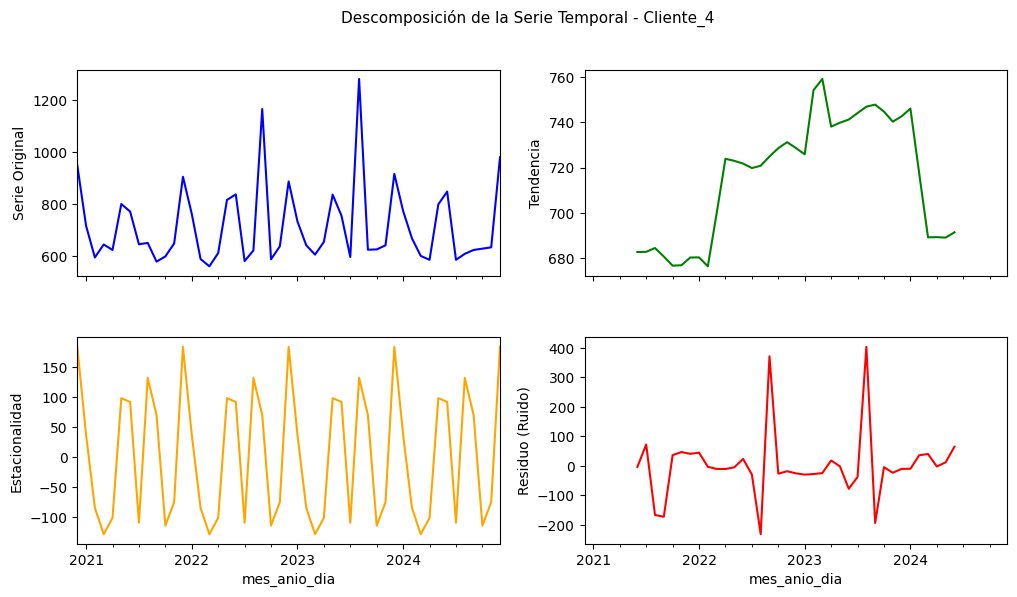

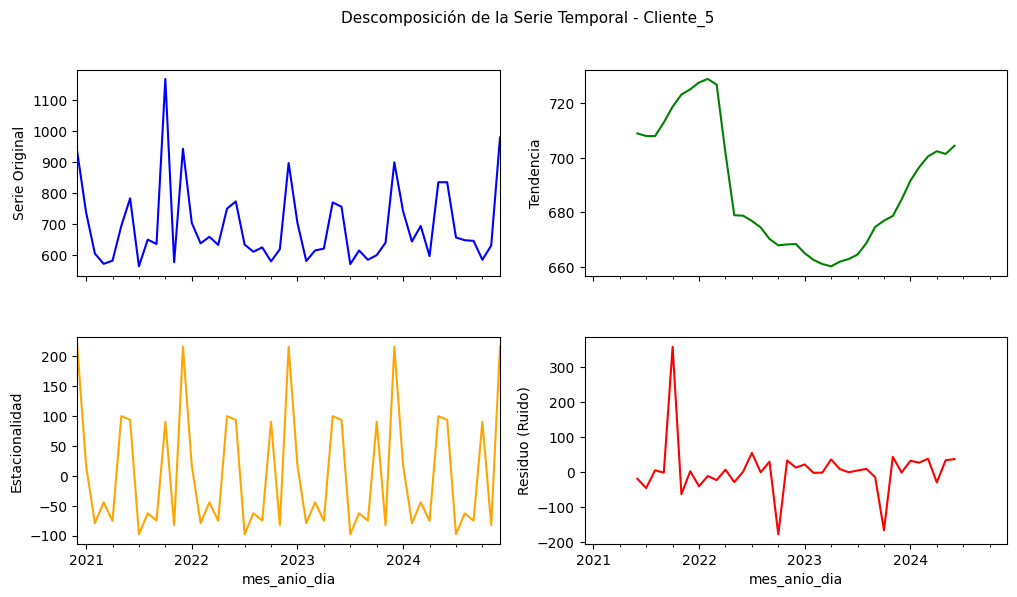

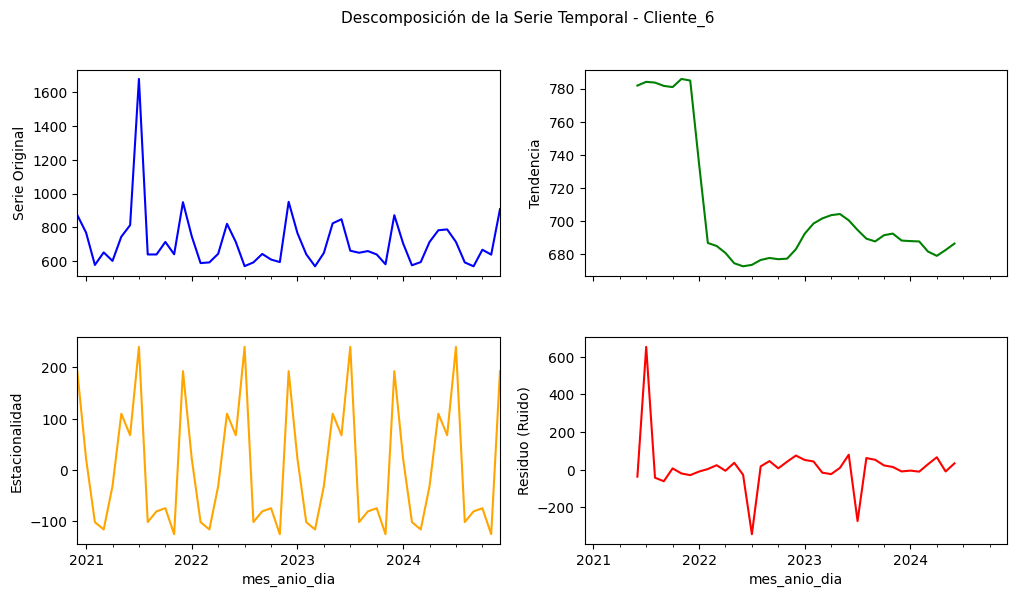

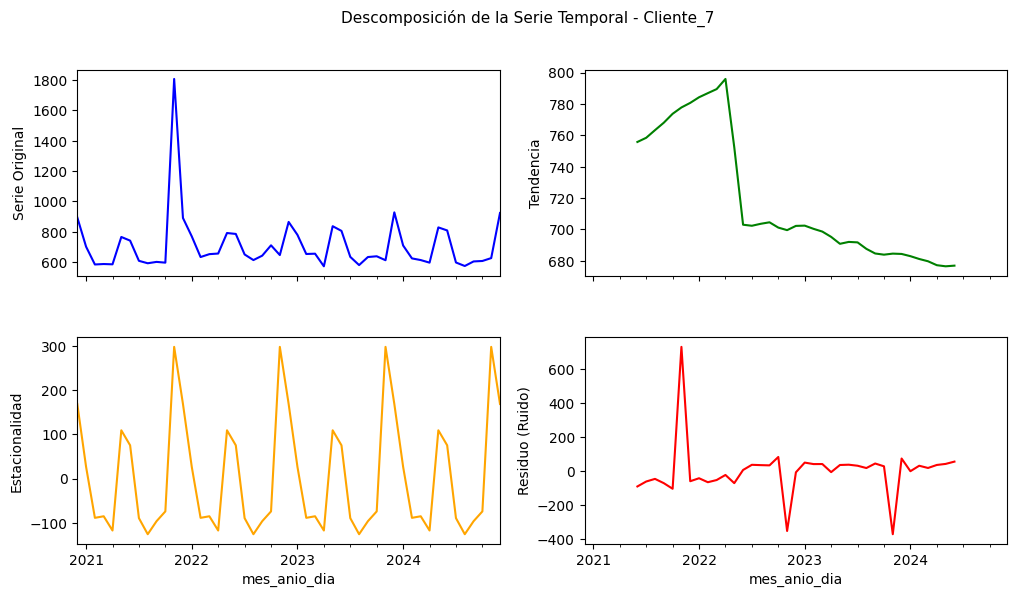

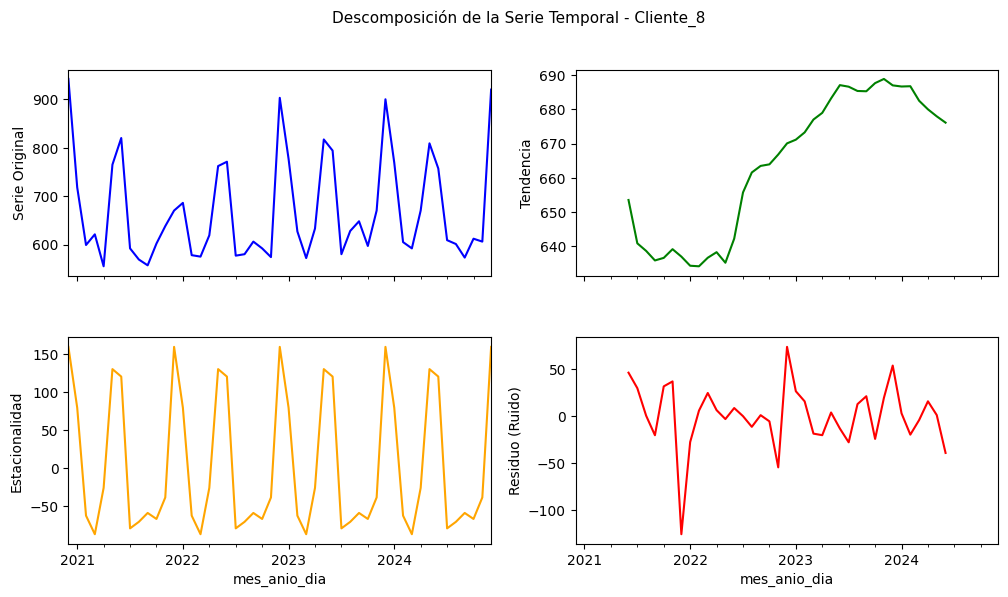

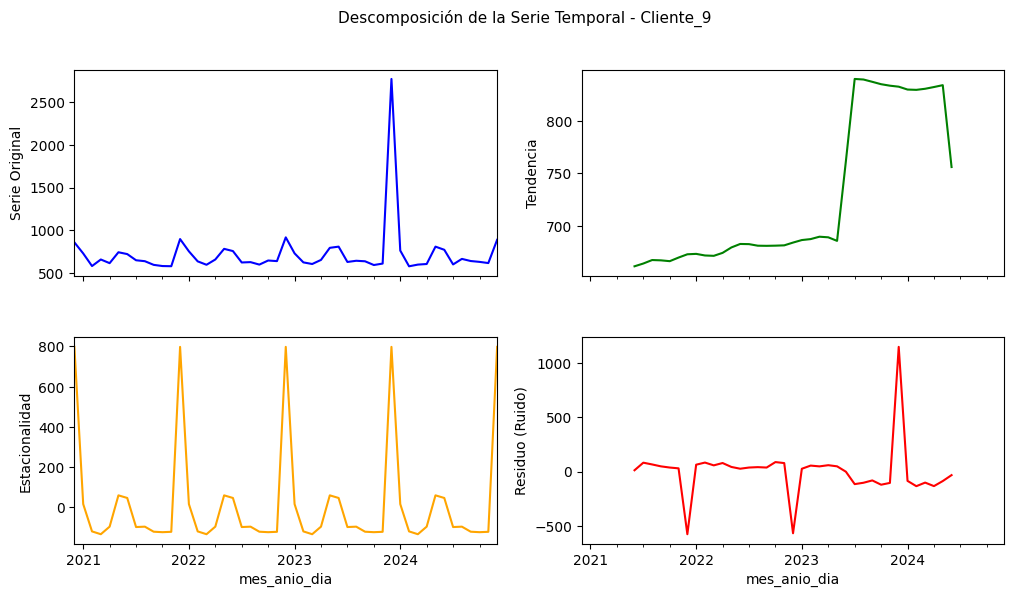

In [11]:
# Descomponer series temporales para cada cliente
for cliente, datos_cliente in clientes_data.items():
    # Establecer la fecha como índice
    datos_cliente = datos_cliente.set_index('mes_anio_dia')

    # Aplicar descomposición estacional (modelo aditivo, periodicidad anual)
    decomposition = seasonal_decompose(datos_cliente['order_demand'], model='additive', period=12)

    # Graficar los componentes en 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    
    decomposition.observed.plot(ax=axes[0, 0], color='blue')
    decomposition.trend.plot(ax=axes[0, 1], color='green')
    decomposition.seasonal.plot(ax=axes[1, 0], color='orange')
    decomposition.resid.plot(ax=axes[1, 1], color='red')

    # Colocar títulos en el lateral izquierdo de cada gráfico
    axes[0, 0].set_ylabel("Serie Original", fontsize=10)
    axes[0, 1].set_ylabel("Tendencia", fontsize=10)
    axes[1, 0].set_ylabel("Estacionalidad", fontsize=10)
    axes[1, 1].set_ylabel("Residuo (Ruido)", fontsize=10)

    # Ajustar título general y evitar superposición
    plt.suptitle(f"Descomposición de la Serie Temporal - {cliente}", fontsize=11, y=1)
    plt.subplots_adjust(top=0.90, hspace=0.3)  # Ajustar espaciado

    plt.show()


2. Correlaciones

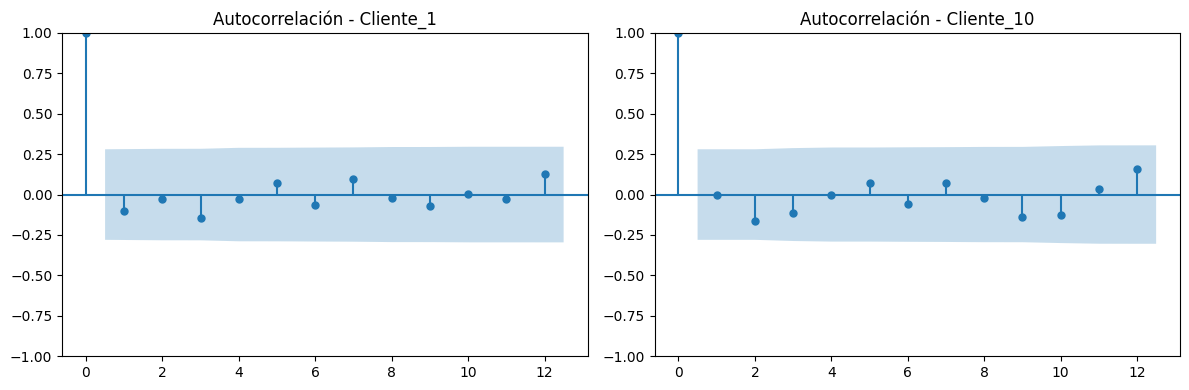

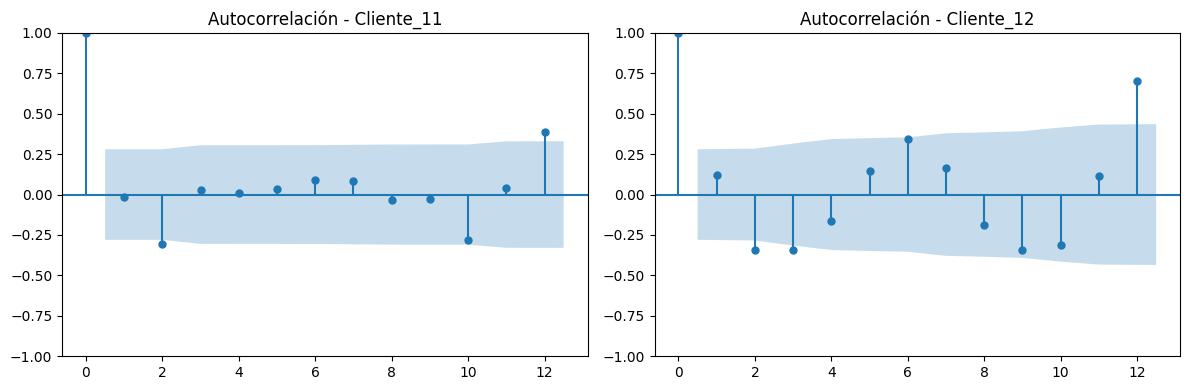

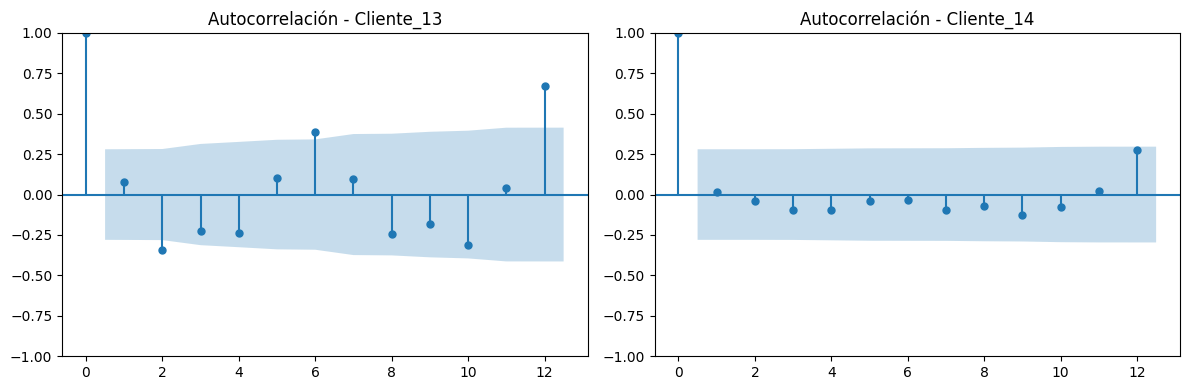

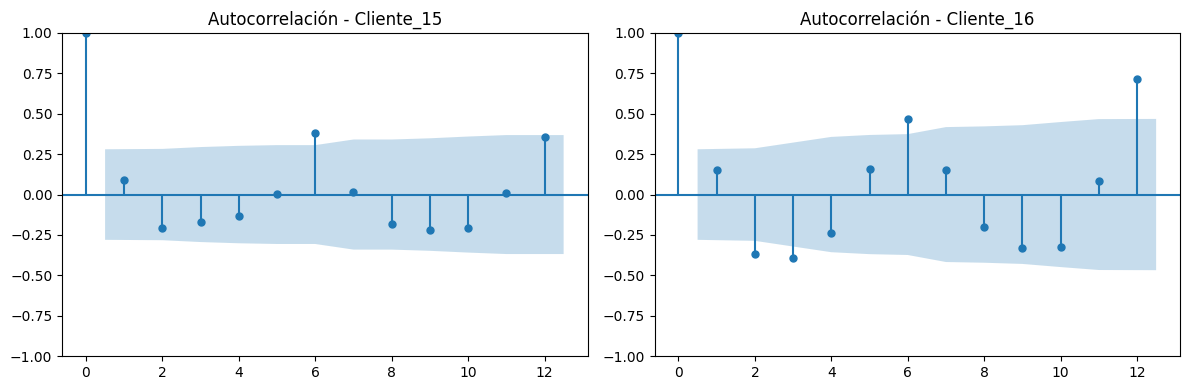

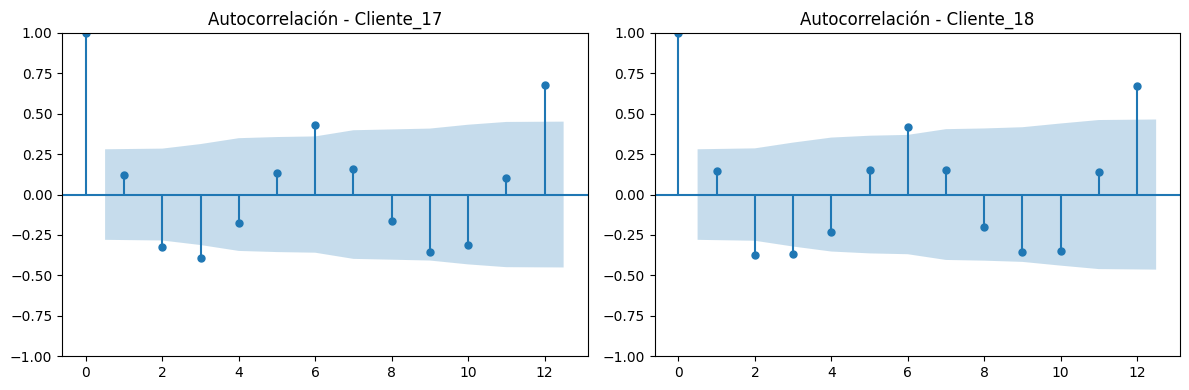

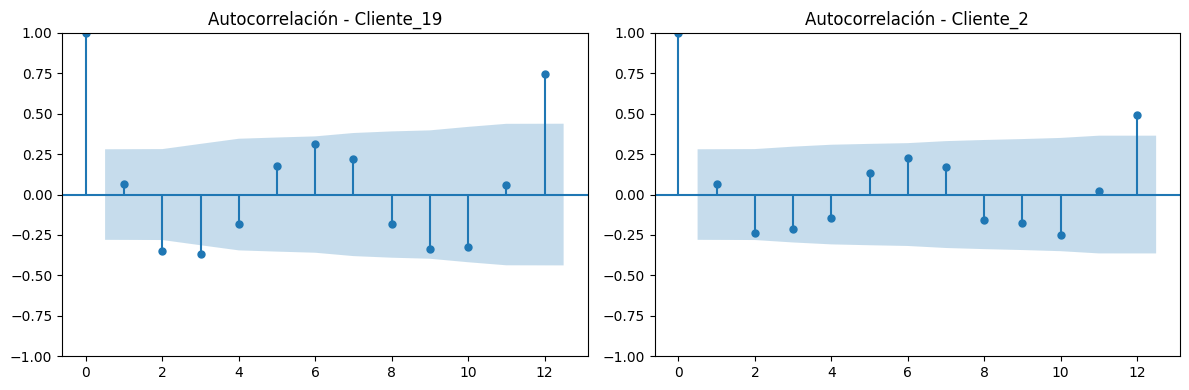

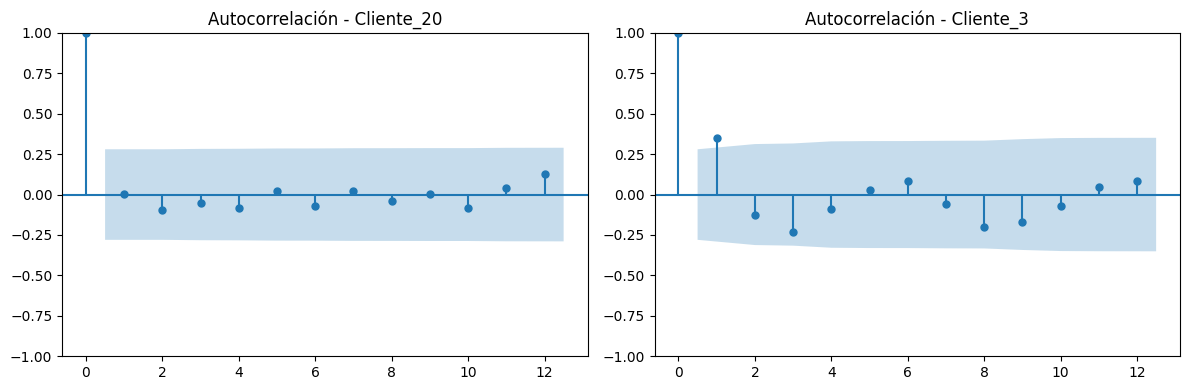

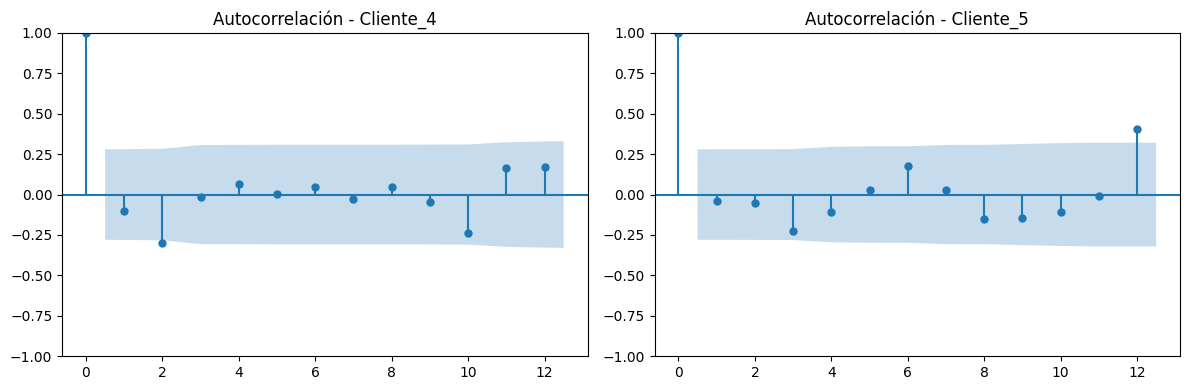

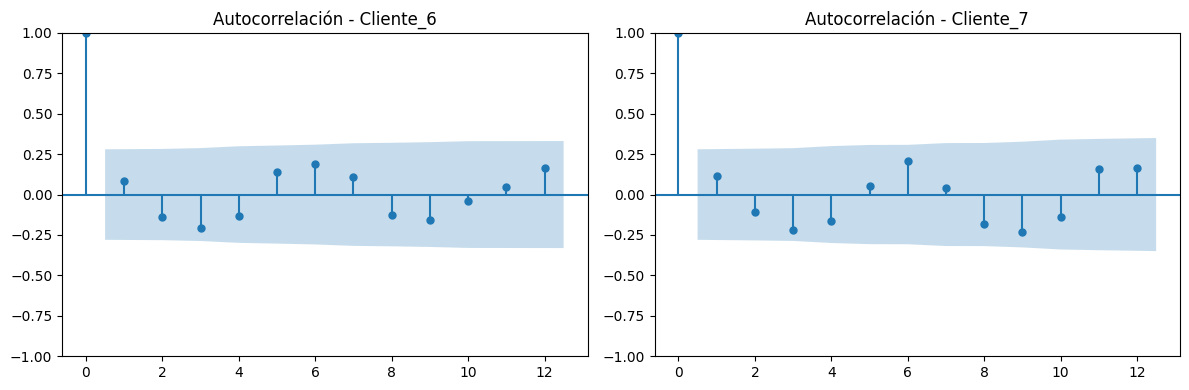

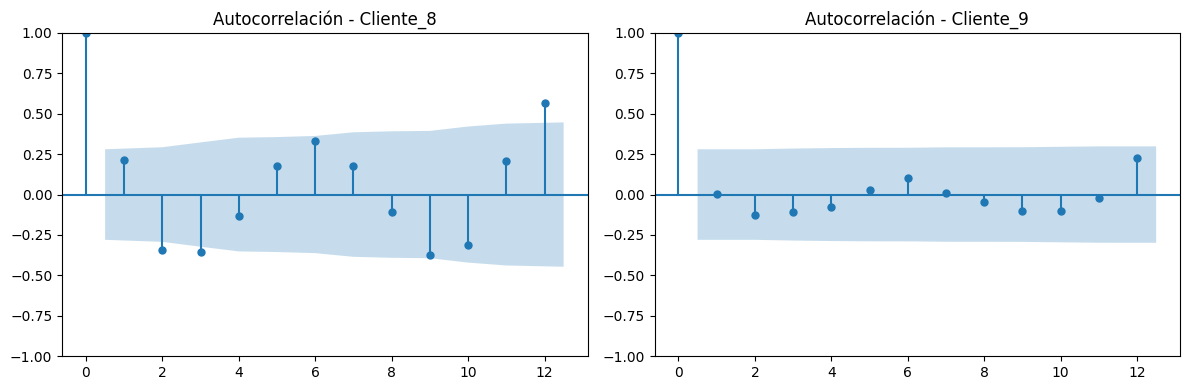

In [12]:
# Correlaciones
clientes = list(clientes_data.keys())  # Obtener la lista de clientes
num_clientes = len(clientes)

# Iterar de dos en dos para mostrar dos gráficos por fila
for i in range(0, num_clientes, 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas

    for j in range(2):  # Para cada columna en la fila
        if i + j < num_clientes:  # Verificar que hay datos suficientes
            cliente = clientes[i + j]
            df = clientes_data[cliente]

            plot_acf(df['order_demand'], lags=12, ax=axes[j])  # Autocorrelación
            axes[j].set_title(f"Autocorrelación - {cliente}")

    plt.tight_layout()
    plt.show()

2. Identificar Tendencias Globales

3. Análisis de Estacionalidad por Cliente

4. Evaluación de Estacionalidad y Ruido

Modelo de Predicción con Regresión Random Forest

In [13]:
# Paso 1: Importar las librerías necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
# Paso 2: Verificar la estructura de datos de un cliente

# Seleccionar un cliente de ejemplo para verificar estructura de datos
cliente_ejemplo = list(clientes_data.keys())[0]
df = clientes_data[cliente_ejemplo]

# Mostrar estructura del DataFrame
print(f"Cliente seleccionado: {cliente_ejemplo}")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())

Cliente seleccionado: Cliente_1
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cliente       49 non-null     object        
 1   mes_anio      49 non-null     object        
 2   order_demand  49 non-null     float64       
 3   mes_anio_dia  49 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.9+ KB
None


In [15]:
# Paso 3: Crear características de series temporales para la predicción

def create_lag_features(df, target_column, lags=12):
    """
    Crea características de rezago (lags) en la serie temporal.

    Args:
        df (DataFrame): DataFrame con los datos de la serie temporal.
        target_column (str): Nombre de la columna objetivo.
        lags (int): Número de lags a generar.

    Returns:
        DataFrame: DataFrame con columnas adicionales de lags.
    """
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)

    return df.dropna()  # Eliminar filas con NaN generadas por el shift

# Aplicar la transformación al DataFrame del cliente de ejemplo
df_lags = create_lag_features(df, target_column='order_demand', lags=12)

# Mostrar las primeras filas para verificar la transformación
print(df_lags.head())


      cliente mes_anio  order_demand mes_anio_dia  lag_1   lag_2   lag_3  \
12  Cliente_1  12-2021         886.0   2021-12-01  597.0  1848.0   589.0   
13  Cliente_1  01-2022         699.0   2022-01-01  886.0   597.0  1848.0   
14  Cliente_1  02-2022         609.0   2022-02-01  699.0   886.0   597.0   
15  Cliente_1  03-2022         633.0   2022-03-01  609.0   699.0   886.0   
16  Cliente_1  04-2022         563.0   2022-04-01  633.0   609.0   699.0   

     lag_4   lag_5   lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  
12   570.0   599.0   798.0  785.0  589.0  631.0   635.0   768.0   857.0  
13   589.0   570.0   599.0  798.0  785.0  589.0   631.0   635.0   768.0  
14  1848.0   589.0   570.0  599.0  798.0  785.0   589.0   631.0   635.0  
15   597.0  1848.0   589.0  570.0  599.0  798.0   785.0   589.0   631.0  
16   886.0   597.0  1848.0  589.0  570.0  599.0   798.0   785.0   589.0  


In [16]:
# Paso 4: Aplicar la transformación de datos para entrenamiento

# Definir el número de lags a considerar
num_lags = 12

# Aplicar la función de transformación al DataFrame del cliente de ejemplo
df_lags = create_lag_features(df, target_column='order_demand', lags=num_lags)

# Asegurar que no haya columnas no numéricas en X
columnas_a_eliminar = ['order_demand', 'cliente', 'mes_anio', 'mes_anio_dia']

# Separar características (X) y variable objetivo (y)
X = df_lags.drop(columns=[col for col in columnas_a_eliminar if col in df_lags.columns], errors='ignore')
X = X.select_dtypes(include=[np.number])  # Mantener solo columnas numéricas
y = df_lags['order_demand']

# Verificar la estructura de los datos transformados
print("Columnas de X después de la limpieza:\n", X.columns)


Columnas de X después de la limpieza:
 Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12'],
      dtype='object')


In [17]:
# Paso 5: Dividir los datos en entrenamiento y prueba

# Dividir en conjunto de entrenamiento y prueba (sin mezclar los datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Verificar las dimensiones de los conjuntos
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (29, 12), X_test shape: (8, 12)
y_train shape: (29,), y_test shape: (8,)


In [18]:
# Paso 6: Optimización de Hiperparámetros con GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en un nodo hoja
    'max_features': ['sqrt', 'log2'],  # Características válidas
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # Criterios para la función de pérdida
    'bootstrap': [True, False],  # Si se debe usar bootstrap
}

# Configurar GridSearchCV con validación cruzada de 3 folds
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimizar el error cuadrático medio
    cv=3,
    verbose=1,
    n_jobs=-1  # Paralelizar la búsqueda
)

# Ajustar el GridSearch a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo entrenado
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("\nMejores Hiperparámetros encontrados:", best_params)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

Mejores Hiperparámetros encontrados: {'bootstrap': False, 'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Hacer predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calcular RMSE manualmente
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 46.23
Mean Squared Error (MSE): 3531.57
Root Mean Squared Error (RMSE): 59.43
R² Score: 0.6779


Predicción

In [21]:
# Diccionario para almacenar las predicciones de cada cliente
predicciones = {}

# Iterar sobre cada cliente en el diccionario de datos
for cliente, df_cliente in clientes_data.items():
    # Asegurar que el DataFrame está ordenado por fecha
    df_cliente = df_cliente.sort_values(by='mes_anio_dia')

    # Seleccionar la última fila para obtener los valores de lag
    ultima_fila = df_cliente.iloc[-1]

    # Construir un DataFrame con una sola fila para la predicción
    X_nueva = pd.DataFrame({
        'lag_1': [ultima_fila['order_demand']],
        'lag_2': [df_cliente.iloc[-2]['order_demand'] if len(df_cliente) > 1 else ultima_fila['order_demand']],
        'lag_3': [df_cliente.iloc[-3]['order_demand'] if len(df_cliente) > 2 else ultima_fila['order_demand']],
        'lag_4': [df_cliente.iloc[-4]['order_demand'] if len(df_cliente) > 3 else ultima_fila['order_demand']],
        'lag_5': [df_cliente.iloc[-5]['order_demand'] if len(df_cliente) > 4 else ultima_fila['order_demand']],
        'lag_6': [df_cliente.iloc[-6]['order_demand'] if len(df_cliente) > 5 else ultima_fila['order_demand']],
        'lag_7': [df_cliente.iloc[-7]['order_demand'] if len(df_cliente) > 6 else ultima_fila['order_demand']],
        'lag_8': [df_cliente.iloc[-8]['order_demand'] if len(df_cliente) > 7 else ultima_fila['order_demand']],
        'lag_9': [df_cliente.iloc[-9]['order_demand'] if len(df_cliente) > 8 else ultima_fila['order_demand']],
        'lag_10': [df_cliente.iloc[-10]['order_demand'] if len(df_cliente) > 9 else ultima_fila['order_demand']],
        'lag_11': [df_cliente.iloc[-11]['order_demand'] if len(df_cliente) > 10 else ultima_fila['order_demand']],
        'lag_12': [df_cliente.iloc[-12]['order_demand'] if len(df_cliente) > 11 else ultima_fila['order_demand']]
    })

    # Usar el modelo para predecir la demanda del siguiente mes
    prediccion = best_rf_model.predict(X_nueva)[0]

    # Guardar la predicción en el diccionario
    predicciones[cliente] = prediccion

# Convertir a DataFrame para visualizar
df_predicciones = pd.DataFrame(list(predicciones.items()), columns=['Cliente', 'Predicción Order_Demand'])
df_predicciones


Cliente  Predicción Order_Demand
0    Cliente_1               714.069444
1   Cliente_10               674.225556
2   Cliente_11               712.085000
3   Cliente_12               689.302778
4   Cliente_13               731.378333
5   Cliente_14               719.182778
6   Cliente_15               725.032778
7   Cliente_16               702.148889
8   Cliente_17               694.782778
9   Cliente_18               712.665000
10  Cliente_19               706.389444
11   Cliente_2               669.074444
12  Cliente_20               730.861667
13   Cliente_3               746.406667
14   Cliente_4               716.418333
15   Cliente_5               701.006667
16   Cliente_6               676.175556
17   Cliente_7               702.356111
18   Cliente_8               711.170000
19   Cliente_9               713.676111

In [ ]:
# Guardar las predicciones en un archivo CSV (opcional)
df_predicciones.to_csv("predicciones_random_forest.csv", index=False)
print("\nPredicciones guardadas en 'predicciones_random_forest.csv'.")

Modelo de ARIMA

In [22]:
# Importat librerías
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")  # Ignorar advertencias para simplificar la salida

In [26]:
# Paso 1: Verificar estructura del DataFrame
df_historicod_time.info()
df_historicod_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cliente       980 non-null    object        
 1   mes_anio      980 non-null    object        
 2   order_demand  980 non-null    float64       
 3   mes_anio_dia  980 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 30.8+ KB


cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01

In [46]:
# Paso 2: Verificar Estacionariedad para todos los clientes
resultados_estacionariedad = {}
clientes_estacionarios = []
clientes_no_estacionarios = []

for cliente, data_cliente in clientes_data.items():
    # Seleccionar solo la columna de demanda y ordenar por fecha
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    # Prueba ADF (Dickey-Fuller Aumentada)
    result_adf = adfuller(data_cliente['order_demand'])
    p_valor = result_adf[1]  # Extraemos el p-valor para verificar la estacionariedad

    # Guardar resultados
    es_estacionaria = p_valor <= 0.05
    resultados_estacionariedad[cliente] = {
        'es_estacionaria': es_estacionaria,
        'p_valor': p_valor,
        'estadistico_adf': result_adf[0],
        'razon': 'Serie estacionaria' if es_estacionaria else 'p-valor > 0.05, no estacionaria'
    }

    # Clasificar correctamente los clientes
    if es_estacionaria:
        clientes_estacionarios.append(cliente)
    else:
        clientes_no_estacionarios.append(cliente)

# Resumen final
print("\nClientes con series estacionarias:")
print(clientes_estacionarios)

print("\nClientes con series no estacionarias:")
print(clientes_no_estacionarios)

# Verificación adicional
print("\nResumen detallado de la prueba Dickey-Fuller:")
for cliente, info in resultados_estacionariedad.items():
    print(f"{cliente}: {info['razon']} (p-valor: {info['p_valor']:.4f})")



Clientes con series estacionarias:
['Cliente_1', 'Cliente_10', 'Cliente_14', 'Cliente_15', 'Cliente_20', 'Cliente_3', 'Cliente_4', 'Cliente_6', 'Cliente_7', 'Cliente_9']

Clientes con series no estacionarias:
['Cliente_11', 'Cliente_12', 'Cliente_13', 'Cliente_16', 'Cliente_17', 'Cliente_18', 'Cliente_19', 'Cliente_2', 'Cliente_5', 'Cliente_8']

Resumen detallado de la prueba Dickey-Fuller:
Cliente_1: Serie estacionaria (p-valor: 0.0000)
Cliente_10: Serie estacionaria (p-valor: 0.0000)
Cliente_11: p-valor > 0.05, no estacionaria (p-valor: 0.9840)
Cliente_12: p-valor > 0.05, no estacionaria (p-valor: 0.8394)
Cliente_13: p-valor > 0.05, no estacionaria (p-valor: 0.6173)
Cliente_14: Serie estacionaria (p-valor: 0.0000)
Cliente_15: Serie estacionaria (p-valor: 0.0000)
Cliente_16: p-valor > 0.05, no estacionaria (p-valor: 0.2869)
Cliente_17: p-valor > 0.05, no estacionaria (p-valor: 0.8727)
Cliente_18: p-valor > 0.05, no estacionaria (p-valor: 0.1637)
Cliente_19: p-valor > 0.05, no estacio

In [51]:
# Paso 3:
# Aplicar diferenciación a las series no estacionarias
clientes_a_diferenciar = clientes_no_estacionarios.copy()
clientes_a_reintentar = []  # Para los clientes que aún no sean estacionarios tras d=1

print("\nResultados de la prueba ADF después de la diferenciación:")

for cliente in clientes_a_diferenciar:
    # Aplicar diferenciación de primer orden (d=1)
    clientes_data[cliente]['order_demand_diff1'] = clientes_data[cliente]['order_demand'].diff().dropna()
    result_adf_diff1 = adfuller(clientes_data[cliente]['order_demand_diff1'].dropna())
    
    # Evaluar si con d=1 la serie ya es estacionaria
    if result_adf_diff1[1] <= 0.05:
        print(f"{cliente} | d=1 | p-valor: {result_adf_diff1[1]:.4f} | Estacionaria")
    else:
        clientes_a_reintentar.append(cliente)
        print(f"{cliente} | d=1 | p-valor: {result_adf_diff1[1]:.4f} | No estacionaria, se probará con d=2")

# Aplicar diferenciación de segundo orden (d=2) si es necesario
if clientes_a_reintentar:
    print("\nAplicando diferenciación de segundo orden (d=2) para clientes restantes...\n")
    for cliente in clientes_a_reintentar:
        # Aplicar diferenciación de segundo orden (d=2)
        clientes_data[cliente]['order_demand_diff2'] = clientes_data[cliente]['order_demand_diff1'].diff().dropna()
        result_adf_diff2 = adfuller(clientes_data[cliente]['order_demand_diff2'].dropna())

        # Evaluar si con d=2 la serie es estacionaria
        if result_adf_diff2[1] <= 0.05:
            print(f"{cliente} | d=2 | p-valor: {result_adf_diff2[1]:.4f} | Estacionaria")
        else:
            print(f"{cliente} | d=2 | p-valor: {result_adf_diff2[1]:.4f} | Aún no estacionaria")



Resultados de la prueba ADF después de la diferenciación:
Cliente_11 | d=1 | p-valor: 0.0138 | Estacionaria
Cliente_12 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_13 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_16 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_17 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_18 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_19 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_2 | d=1 | p-valor: 0.0001 | Estacionaria
Cliente_5 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_8 | d=1 | p-valor: 0.0001 | Estacionaria


In [57]:
# Asignar d_inicial
# Crear diccionario para almacenar el valor de d inicial
d_inicial_por_cliente = {}

# Asignar d=0 a los clientes que eran estacionarios desde el inicio
for cliente in clientes_estacionarios:
    d_inicial_por_cliente[cliente] = 0  

# Asignar d=1 a los clientes que requirieron diferenciación
for cliente in clientes_no_estacionarios:  # Es lo mismo que clientes_diferenciados
    d_inicial_por_cliente[cliente] = 1  

# Mostrar los valores asignados
print("Parámetro d inicial por cliente:")
for cliente, d in d_inicial_por_cliente.items():
    print(f"{cliente}: d={d}")


Parámetro d inicial por cliente:
Cliente_1: d=0
Cliente_10: d=0
Cliente_14: d=0
Cliente_15: d=0
Cliente_20: d=0
Cliente_3: d=0
Cliente_4: d=0
Cliente_6: d=0
Cliente_7: d=0
Cliente_9: d=0
Cliente_11: d=1
Cliente_12: d=1
Cliente_13: d=1
Cliente_16: d=1
Cliente_17: d=1
Cliente_18: d=1
Cliente_19: d=1
Cliente_2: d=1
Cliente_5: d=1
Cliente_8: d=1


In [61]:
# Paso 4: Determinar los mejores parámetros (p, d, q) para ARIMA

best_models = {}

# Rango de valores a probar para p y q (d ya está fijo por cliente)
p_values = range(0, 3)  # p = 0,1,2
q_values = range(0, 3)  # q = 0,1,2

# Iterar sobre cada cliente en clientes_data
for cliente, data_cliente in clientes_data.items():
    
    # Seleccionar la serie temporal y ordenar por fecha
    series_to_use = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()
    series_to_use = series_to_use['order_demand'].dropna()

    # Asignar el valor de d según el análisis previo
    d = d_inicial_por_cliente[cliente]

    best_aic = np.inf  # Iniciar con un valor infinito
    best_order = None
    best_model = None

    # Probar combinaciones de parámetros p y q (d ya está fijo)
    for p in p_values:
        for q in q_values:
            try:
                model = ARIMA(series_to_use, order=(p, d, q))
                model_fit = model.fit()

                # Evaluar AIC
                aic = model_fit.aic

                # Guardar el mejor modelo encontrado
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception as e:
                continue  # Ignorar errores y continuar con la siguiente combinación

    # Almacenar el mejor modelo para este cliente
    best_models[cliente] = {
        'model': best_model,
        'order': best_order,
        'aic': best_aic
    }
    print(f"Mejor modelo para {cliente}: ARIMA{best_order} - AIC: {best_aic}")


Mejor modelo para Cliente_1: ARIMA(0, 0, 0) - AIC: 659.2198207475262
Mejor modelo para Cliente_10: ARIMA(0, 0, 0) - AIC: 689.6073918235395
Mejor modelo para Cliente_11: ARIMA(2, 1, 1) - AIC: 606.6197498173262
Mejor modelo para Cliente_12: ARIMA(2, 1, 2) - AIC: 588.0695511793515
Mejor modelo para Cliente_13: ARIMA(2, 1, 2) - AIC: 588.5811385739278
Mejor modelo para Cliente_14: ARIMA(0, 0, 0) - AIC: 623.1938569811233
Mejor modelo para Cliente_15: ARIMA(2, 0, 2) - AIC: 639.6861588331666
Mejor modelo para Cliente_16: ARIMA(2, 1, 2) - AIC: 576.0209308078336
Mejor modelo para Cliente_17: ARIMA(2, 1, 2) - AIC: 589.2778861253635
Mejor modelo para Cliente_18: ARIMA(2, 1, 2) - AIC: 583.1379070074023
Mejor modelo para Cliente_19: ARIMA(2, 1, 2) - AIC: 578.1261933111332
Mejor modelo para Cliente_2: ARIMA(2, 1, 1) - AIC: 585.851221984425
Mejor modelo para Cliente_20: ARIMA(0, 0, 0) - AIC: 698.3232984290439
Mejor modelo para Cliente_3: ARIMA(2, 0, 0) - AIC: 655.7758949280923
Mejor modelo para Client

In [53]:
# Paso 4: Determinar los mejores parámetros (p, d, q) para ARIMA
best_models = {}

for cliente, data_cliente in clientes_data.items():
    #print(f"\nProcesando cliente: {cliente}")

    # Seleccionar solo la columna de demanda y ordenar por fecha
    series_to_use = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()['order_demand']

    best_aic = np.inf
    best_order = None
    best_model = None

    # Probar combinaciones de parámetros p, d, q
    for p in range(0, 3):
        for d in range(0, 3):  # Aunque ya hemos diferenciado, probamos variantes
            for q in range(0, 3):
                try:
                    model = ARIMA(series_to_use, order=(p, d, q))
                    model_fit = model.fit()

                    # Evaluar AIC
                    aic = model_fit.aic

                    # Guardar el mejor modelo basado en AIC
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except:
                    continue  # Evitar errores por combinaciones inválidas

    # Almacenar el mejor modelo para este cliente
    best_models[cliente] = {
        'model': best_model,
        'order': best_order,
        'aic': best_aic
    }
    
    print(f"Mejor modelo para {cliente}: ARIMA{best_order} - AIC: {best_aic:.2f}")


Mejor modelo para Cliente_1: ARIMA(0, 2, 2) - AIC: 648.13
Mejor modelo para Cliente_10: ARIMA(0, 2, 2) - AIC: 677.56
Mejor modelo para Cliente_11: ARIMA(2, 2, 2) - AIC: 600.96
Mejor modelo para Cliente_12: ARIMA(2, 0, 2) - AIC: 584.58
Mejor modelo para Cliente_13: ARIMA(2, 1, 2) - AIC: 588.58
Mejor modelo para Cliente_14: ARIMA(0, 2, 2) - AIC: 613.81
Mejor modelo para Cliente_15: ARIMA(0, 2, 2) - AIC: 634.27
Mejor modelo para Cliente_16: ARIMA(2, 1, 2) - AIC: 576.02
Mejor modelo para Cliente_17: ARIMA(2, 0, 2) - AIC: 580.65
Mejor modelo para Cliente_18: ARIMA(2, 1, 2) - AIC: 583.14
Mejor modelo para Cliente_19: ARIMA(2, 1, 2) - AIC: 578.13
Mejor modelo para Cliente_2: ARIMA(0, 2, 2) - AIC: 583.33
Mejor modelo para Cliente_20: ARIMA(2, 2, 2) - AIC: 10.00
Mejor modelo para Cliente_3: ARIMA(0, 1, 2) - AIC: 646.57
Mejor modelo para Cliente_4: ARIMA(2, 2, 2) - AIC: 626.03
Mejor modelo para Cliente_5: ARIMA(0, 2, 2) - AIC: 608.77
Mejor modelo para Cliente_6: ARIMA(0, 2, 2) - AIC: 637.40
Mejo

In [44]:
# Paso 2: Verificar Estacionariedad para todos los clientes
resultados_estacionariedad = {}

for cliente in df_historicod_time['cliente'].unique():
    print(f"\nVerificando estacionariedad para el cliente: {cliente}")
    
    # Filtrar datos por cliente
    data_cliente = df_historicod_time[df_historicod_time['cliente'] == cliente]
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    series_to_use = data_cliente['order_demand'].dropna()

    # Prueba ADF (Dickey-Fuller Aumentada)
    result_adf = adfuller(series_to_use)
    print("Resultados de la prueba ADF:")
    print(f"Estadístico ADF: {result_adf[0]}")
    print(f"p-valor: {result_adf[1]}")
    print(f"Valores críticos: {result_adf[4]}")

    # Guardar resultados
    resultados_estacionariedad[cliente] = {
        'es_estacionaria': result_adf[1] <= 0.05,
        'p_valor': result_adf[1],
        'estadistico_adf': result_adf[0],
        'razon': 'p-valor > 0.05, no estacionaria' if result_adf[1] > 0.05 else 'Serie estacionaria'
    }

    # Interpretación
    if result_adf[1] > 0.05:
        print(f"La serie para {cliente} no es estacionaria. Puede requerir diferenciación.")
    else:
        print(f"La serie para {cliente} es estacionaria.")

# Análisis final
print("\nResumen de estacionariedad:")
todas_estacionarias = all(info['es_estacionaria'] for info in resultados_estacionariedad.values())

if todas_estacionarias:
    print("Todas las series son estacionarias.")
else:
    print("Algunas series no son estacionarias:")
    for cliente, info in resultados_estacionariedad.items():
        if not info['es_estacionaria']:
            print(f"- {cliente}: {info['razon']} (p-valor: {info['p_valor']})")



Verificando estacionariedad para el cliente: Cliente_1
Resultados de la prueba ADF:
Estadístico ADF: -7.486202499230385
p-valor: 4.632046187009797e-11
Valores críticos: {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
La serie para Cliente_1 es estacionaria.

Verificando estacionariedad para el cliente: Cliente_10
Resultados de la prueba ADF:
Estadístico ADF: -6.776935409827234
p-valor: 2.5566161236470103e-09
Valores críticos: {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
La serie para Cliente_10 es estacionaria.

Verificando estacionariedad para el cliente: Cliente_11
Resultados de la prueba ADF:
Estadístico ADF: 0.47104067280503864
p-valor: 0.9839658086112942
Valores críticos: {'1%': np.float64(-3.6209175221605827), '5%': np.float64(-2.9435394610388332), '10%': np.float64(-2.6104002410518627)}
La serie para Cliente_11 no es estacionaria. Pued

In [ ]:
# Verificar si hay series no estacionarias
if len(series_no_estacionarias) > 0:
    print("Series no estacionarias encontradas:\n")
    
    # Iterar por cada cliente y razones en el diccionario
    for cliente, razones in series_no_estacionarias.items():
        print(f"Cliente: {cliente}")
        print(f"Razones por las que no es estacionaria: {razones}")
        print("-" * 50)
else:
    print("No se encontraron series no estacionarias.")


In [29]:
# Paso 4: Probar combinaciones de parámetros p, d, q
best_models = {}

for cliente in df_historic_order_demand['cliente'].unique():
    print(f"\nProcesando cliente: {cliente}")
    
    # Filtrar datos por cliente
    data_cliente = df_historic_order_demand[df_historic_order_demand['cliente'] == cliente]
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    series_to_use = data_cliente['order_demand'].dropna()

    best_aic = np.inf
    best_order = None
    best_model = None

    # Probar combinaciones de parámetros
    for p in range(0, 3):
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(series_to_use, order=(p, d, q))
                    model_fit = model.fit()

                    # Evaluar AIC
                    aic = model_fit.aic

                    # Mostrar solo las combinaciones que mejoren el AIC
                    if aic < best_aic:
                        print(f"Mejorado: ARIMA({p}, {d}, {q}) - AIC: {aic}")
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    continue

    # Guardar el mejor modelo encontrado
    best_models[cliente] = {
        'model': best_model,
        'order': best_order,
        'aic': best_aic
    }
    print(f"Mejor modelo para {cliente}: ARIMA{best_order} - AIC: {best_aic}")


NameError: name 'modelos_ajustados' is not defined


Evaluando residuos para el cliente: Cliente_1


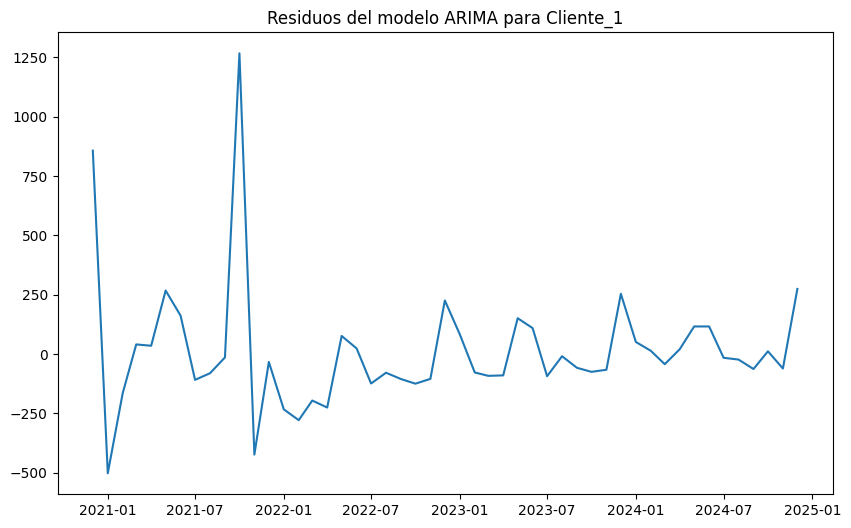


Evaluando residuos para el cliente: Cliente_10


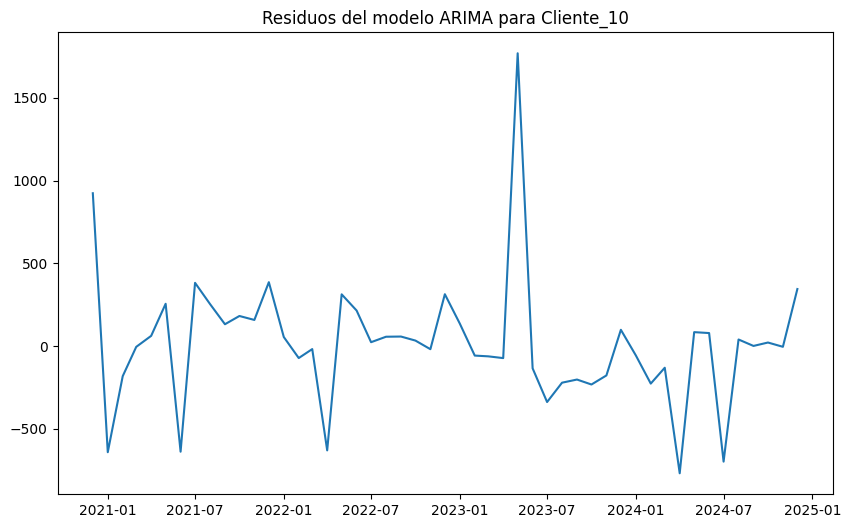


Evaluando residuos para el cliente: Cliente_11


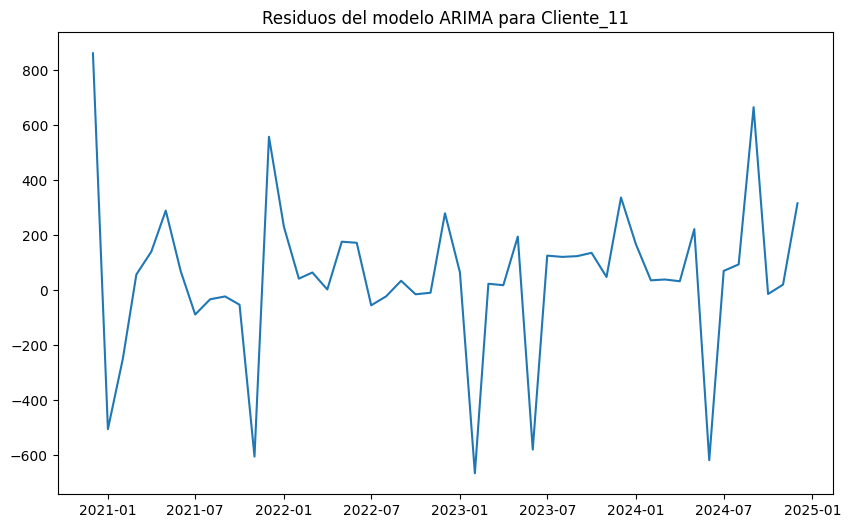


Evaluando residuos para el cliente: Cliente_12


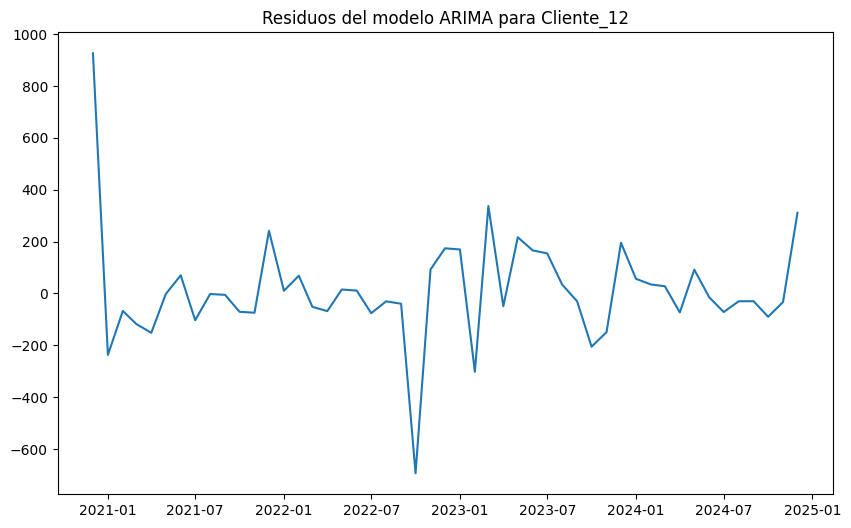


Evaluando residuos para el cliente: Cliente_13


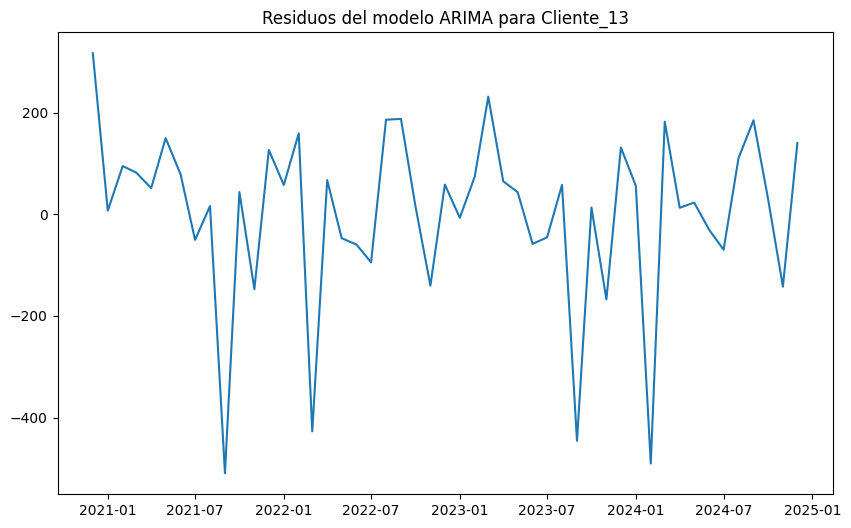


Evaluando residuos para el cliente: Cliente_14


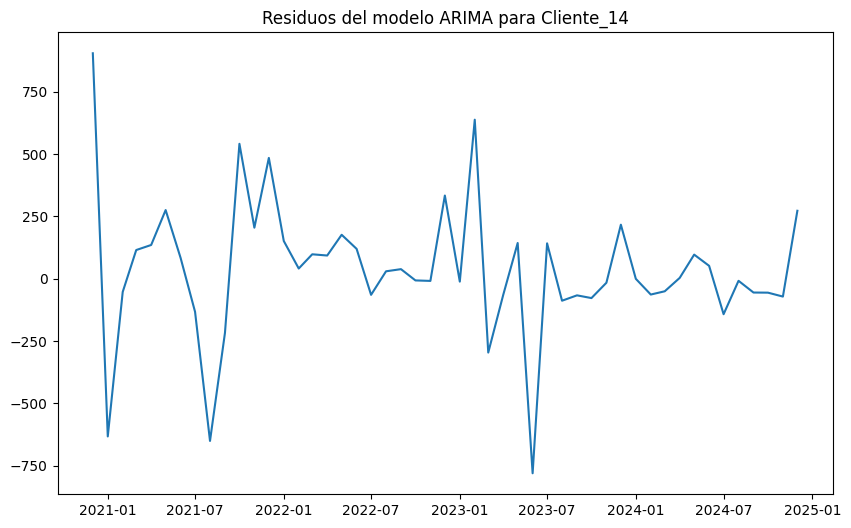


Evaluando residuos para el cliente: Cliente_15


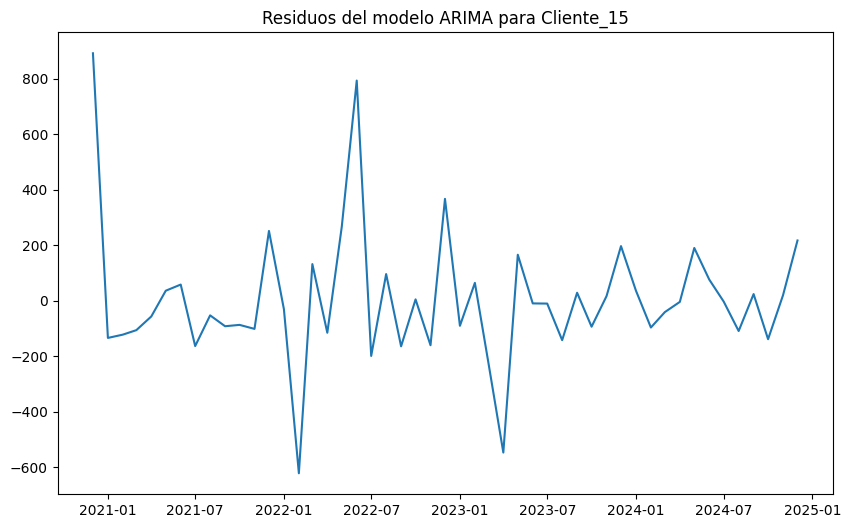


Evaluando residuos para el cliente: Cliente_16


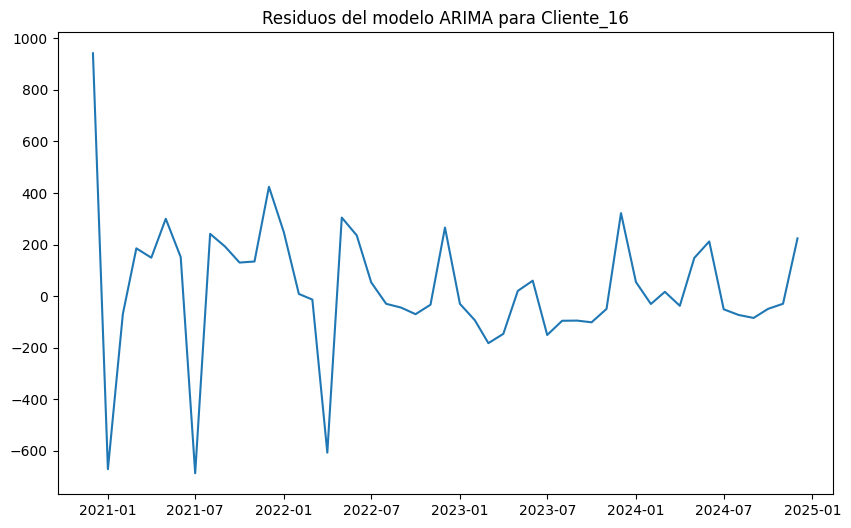


Evaluando residuos para el cliente: Cliente_17


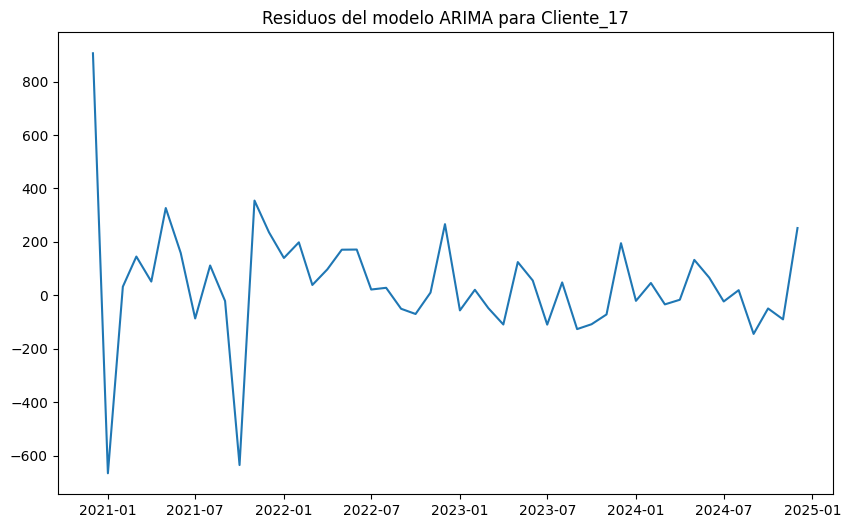


Evaluando residuos para el cliente: Cliente_18


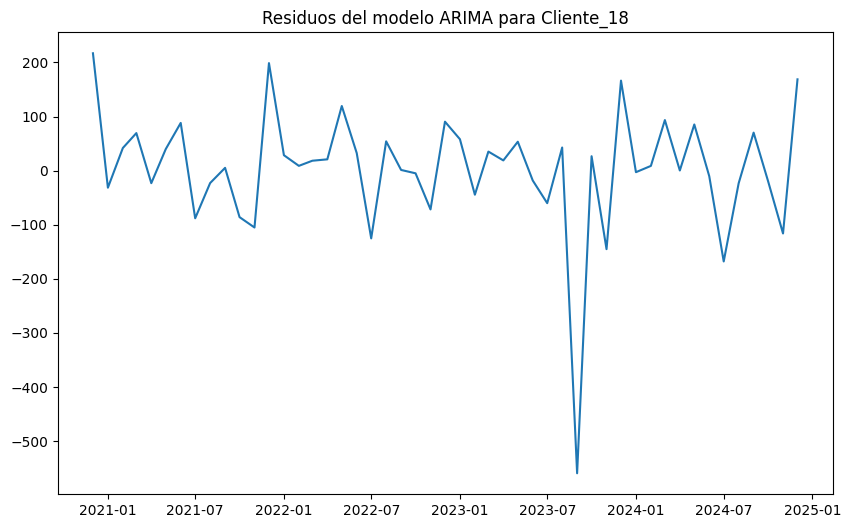


Evaluando residuos para el cliente: Cliente_19


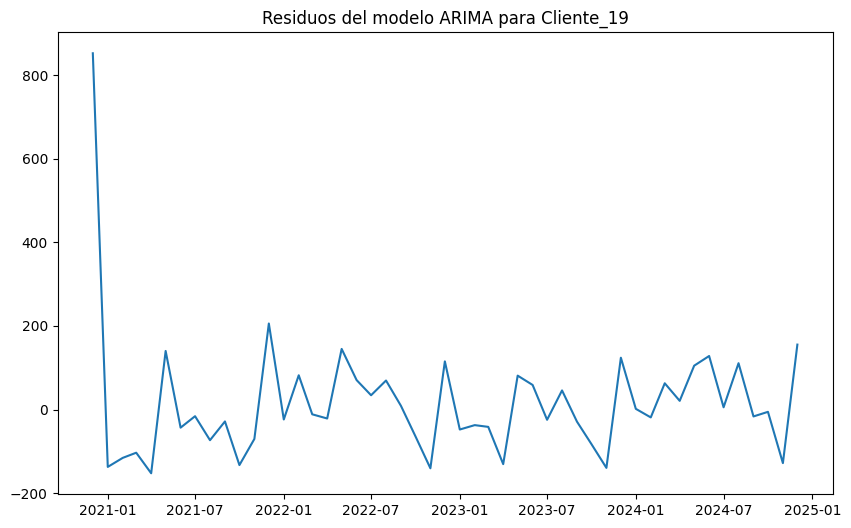


Evaluando residuos para el cliente: Cliente_2


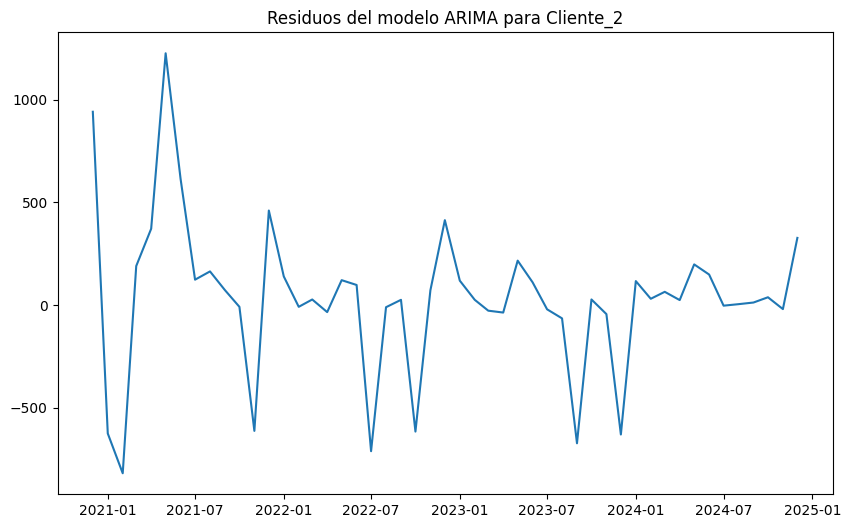


Evaluando residuos para el cliente: Cliente_20


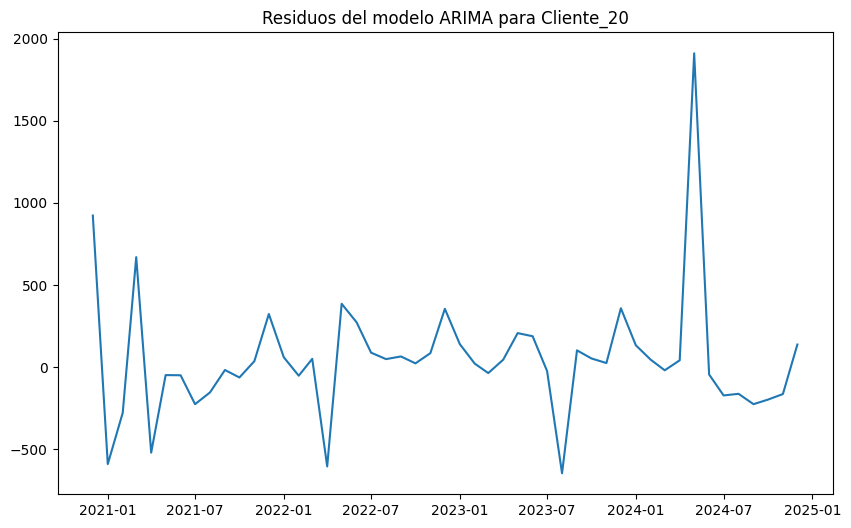


Evaluando residuos para el cliente: Cliente_3


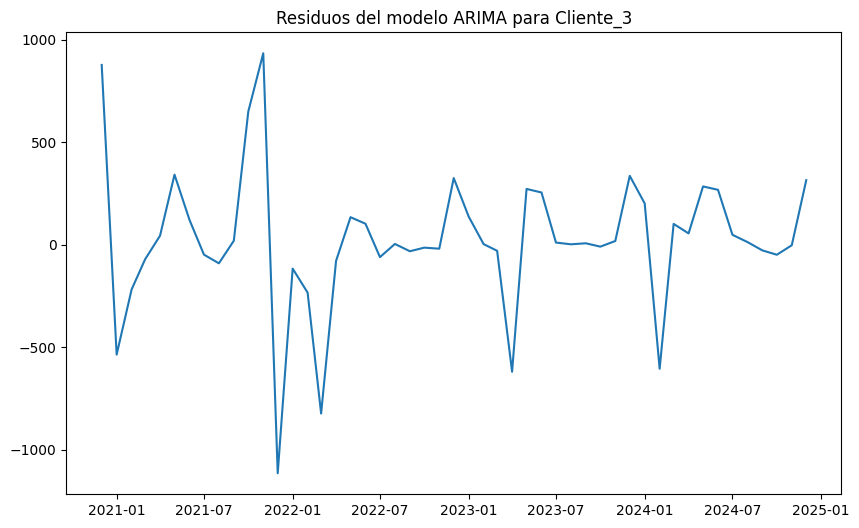


Evaluando residuos para el cliente: Cliente_4


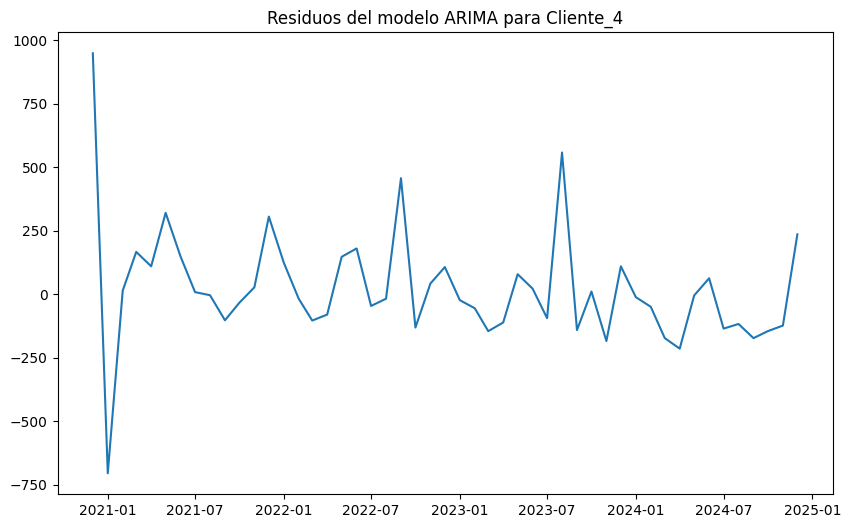


Evaluando residuos para el cliente: Cliente_5


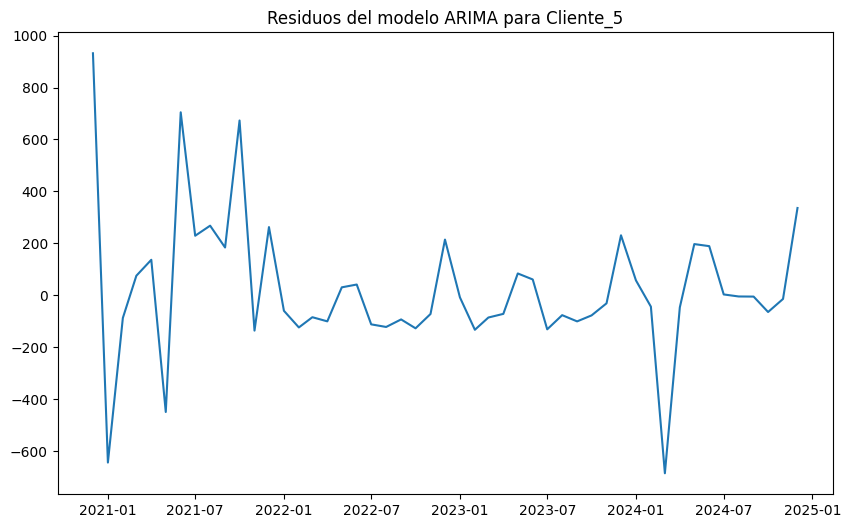


Evaluando residuos para el cliente: Cliente_6


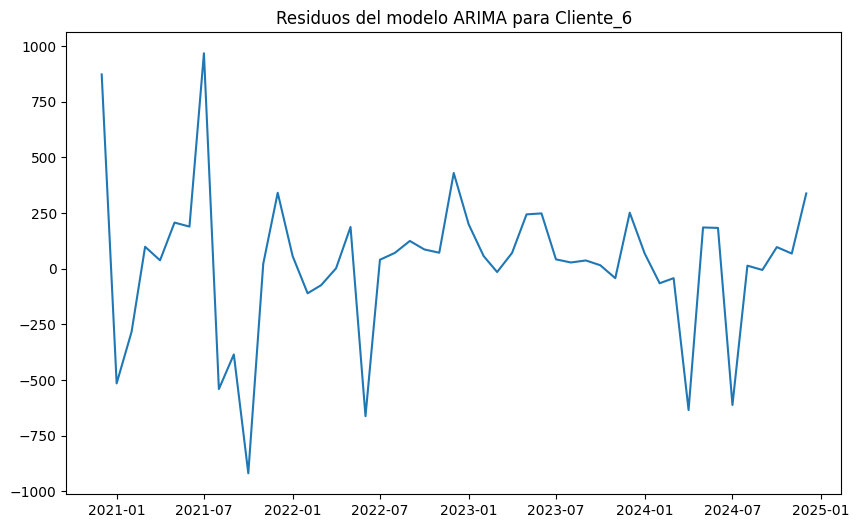


Evaluando residuos para el cliente: Cliente_7


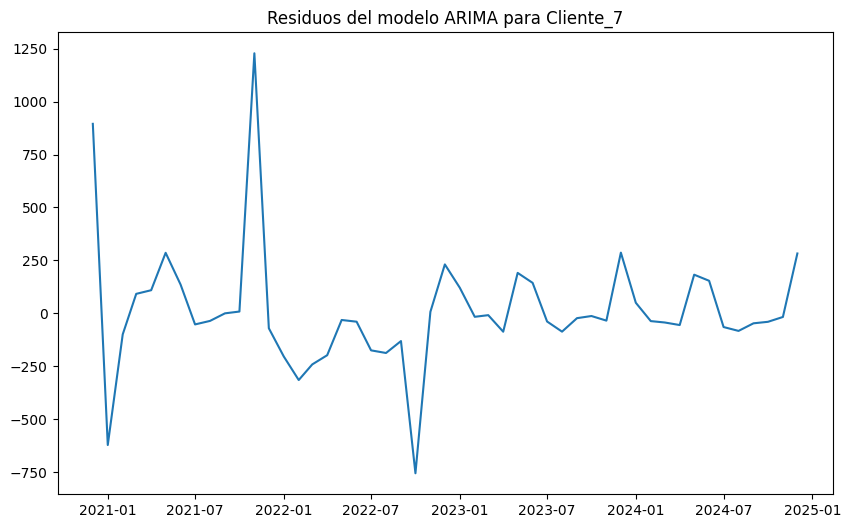


Evaluando residuos para el cliente: Cliente_8


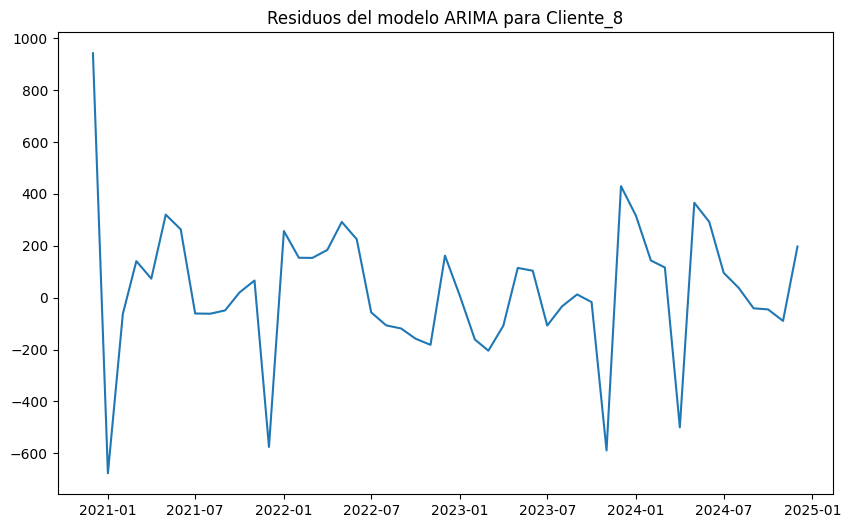


Evaluando residuos para el cliente: Cliente_9


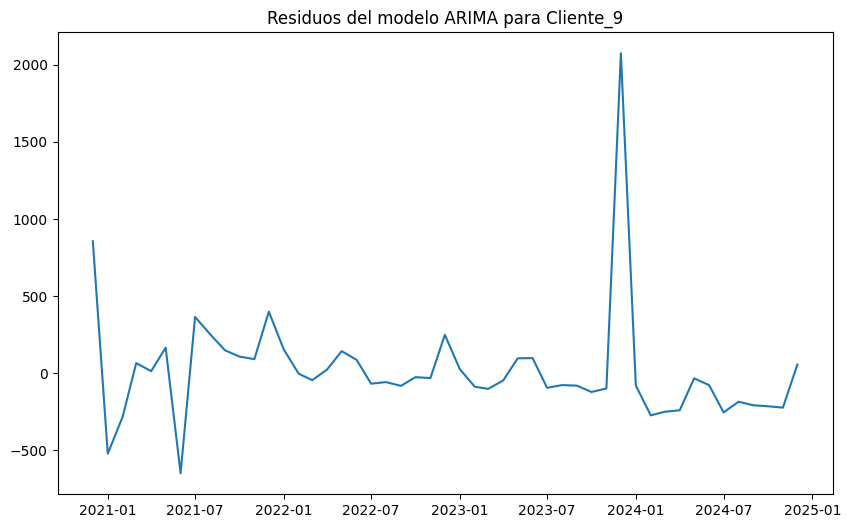

In [25]:
# Paso 4: Evaluación de Residuos
for cliente, model_info in best_models.items():
    if model_info['model']:
        residuals = model_info['model'].resid
        print(f"\nEvaluando residuos para el cliente: {cliente}")

        plt.figure(figsize=(10, 6))
        plt.plot(residuals)
        plt.title(f"Residuos del modelo ARIMA para {cliente}")
        plt.show()
    else:
        print(f"No se encontró un modelo adecuado para el cliente: {cliente}.")


In [26]:
# Paso 5: Predicción para el próximo mes
predicciones = {}

for cliente, model_info in best_models.items():
    if model_info['model']:
        prediccion = model_info['model'].get_forecast(steps=1)
        prediccion_intervalo = prediccion.conf_int()
        prediccion_valor = prediccion.predicted_mean.iloc[0]

        print(f"\nDemanda estimada para {cliente} el próximo mes: {prediccion_valor}")
        print("Intervalo de confianza:")
        print(prediccion_intervalo)

        # Guardar predicción
        predicciones[cliente] = {
            'prediccion': prediccion_valor,
            'intervalo_confianza': prediccion_intervalo
        }
    else:
        print(f"No se encontró un modelo adecuado para {cliente}.")



Demanda estimada para Cliente_1 el próximo mes: 654.1124974010877
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          254.444798         1053.780196

Demanda estimada para Cliente_10 el próximo mes: 658.9344060447742
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          -33.782637         1351.651449

Demanda estimada para Cliente_11 el próximo mes: 656.5078488070179
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          180.088348          1132.92735

Demanda estimada para Cliente_12 el próximo mes: 691.563267650842
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          374.558573         1008.567962

Demanda estimada para Cliente_13 el próximo mes: 677.634602046357
Intervalo de confianza:
            lower order_demand  upper order_demand
2025-01-01          353.762014          1001.50719

Demanda estimada para Cliente_14


Aquí están algunas técnicas que podríamos considerar:

Series Temporales (como ARIMA, SARIMA): Estos modelos son útiles para datos con tendencias y patrones estacionales, que pueden ser comunes en datos de pedidos.

Modelos de Regresión: Podemos usar regresiones lineales o múltiples si la demanda está influenciada por múltiples factores externos o internos que están representados en los datos.

Machine Learning (como Random Forests, Gradient Boosting Machines): Estos modelos pueden capturar complejidades no lineales y interacciones entre variables que los modelos más simples pueden pasar por alto.